# **Install Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import Aer
from qiskit.opflow import CircuitSampler, PauliOp, MatrixEvolution, Suzuki
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, CX, CZ, Swap
from qiskit.circuit import Parameter
from qiskit import (
    QuantumCircuit,
    Aer,
    assemble,
    QuantumRegister,
    IBMQ,
    execute,
    transpile,
)
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import HamiltonianGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import random
from qiskit.tools.visualization import circuit_drawer
import warnings
import math

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (20, 10)

C:\Users\chen9\AppData\Local\Temp\ipykernel_53480\3391482448.py:5: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import CircuitSampler, PauliOp, MatrixEvolution, Suzuki


# **1 Qubit**

In [ ]:
def qubit_1(psi, g, delta_t, delta_x, V0, V1, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = X
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    psi0_2, psi1_2 = psi[0] ** 2, psi[1] ** 2
    prob0 = [psi0_2]

    # step 1
    qc = QuantumCircuit(1)
    qc.initialize(psi, 0)
    qc.append(U, [0])

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    # print(counts)
    if "0" in counts:
        psi0_2 = counts["0"] / N
    else:
        psi0_2 = 0
    if "1" in counts:
        psi1_2 = counts["1"] / N
    else:
        psi1_2 = 0

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(1)
        qc.initialize(psi, 0)

        # step 6

        V.append(
            Operator(
                [
                    [np.exp(((0 + 1j) * (g * psi0_2 - V0)) * delta_t), 0],
                    [0, np.exp(((0 + 1j) * (g * psi1_2 - V1)) * delta_t)],
                ]
            )
        )  # append V_j
        for i in range(j + 1):
            qc.append(U, [0])  # U
            qc.append(V[i], [0])  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(copy)
        if "0" in counts:
            psi0_2 = counts["0"] / N
            prob0.append(psi0_2)
        else:
            prob0.append(0)
        if "1" in counts:
            psi1_2 = counts["1"] / N

        # step 7
        qc.append(U, [0])

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc)
        # print(counts)
        if "0" in counts:
            psi0_2 = counts["0"] / N
        else:
            psi0_2 = 0
        if "1" in counts:
            psi1_2 = counts["1"] / N
        else:
            psi1_2 = 0
    plt.xlabel("n")
    plt.ylabel(r"$|\psi_0|^2$")
    title = r"$\Delta t$=" + str(delta_t)
    plt.title(title)
    plt.plot(prob0, color=color)
    # print(prob0)

In [ ]:
psi = [math.cos(math.pi / 6), math.sin(math.pi / 6)]
V0, V1 = 0, 0
qubit_1(psi, 1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "red")
qubit_1(psi, 0, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "black")
qubit_1(psi, -1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "blue")

In [ ]:
psi = [math.cos(math.pi / 4), math.sin(math.pi / 4)]
V0, V1 = -1, 0
qubit_1(psi, 1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "red")
qubit_1(psi, 0, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "black")
qubit_1(psi, -1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "blue")

# 2 Qubits

In [5]:
def get_prob(counts, N):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: counts[i] for i in keys}
    for key in counts:
        counts[key] /= N
    counts = list(counts.items())
    # print(counts)
    prob = [0 for i in range(4)]
    for i in range(len(counts)):
        prob[int(counts[i][0], 2)] = counts[i][1]
    return prob


def qubit_2(psi, g, delta_t, delta_x, V_diag, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = (((I + X)) ^ X) + (((-2 * I) ^ I))
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    data = []

    # step 1
    qc = QuantumCircuit(2)
    qc.initialize(psi, qc.qubits)
    qc.append(U, [0, 1])

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc), N)
    # print(prob)

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(2)
        qc.initialize(psi, [0, 1])

        # step 6
        Op = [[0 for k in range(4)] for i in range(4)]
        for i in range(4):
            Op[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        V.append(Operator(Op))  # append V_j
        for i in range(j + 1):
            qc.append(U, [0, 1])  # U
            qc.append(V[i], [0, 1])  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N)
        data.append(prob)

        # step 7
        qc.append(U, [0, 1])

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(qc), N)

    """
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  """
    data = np.array(data).T
    for i in range(4):
        plt.plot(data[i])
    return

In [ ]:
psi = [1 / 2, 1 / 2, 1 / 2, 1 / 2]
V_diag = [1, 0, 0, 0]
qubit_2(psi, 1, 0.1, 1 / math.sqrt(2), V_diag, 100, 1024, "red")

# **Multiple Qubits (Cyclic)**



In [2]:
def get_prob(counts, N, numQubits):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: counts[i] for i in keys}
    for key in counts:
        counts[key] /= N
    counts = list(counts.items())
    prob = [0 for i in range(2**numQubits)]
    # prob = np.zeros(2**numQubits) #[0 for i in range(2**numQubits)]
    for i in range(len(counts)):
        prob[int(counts[i][0], 2)] = counts[i][1]
    return prob


def L_diag(numQubits):
    if numQubits == 1:
        return -2 * I
    return L_diag(numQubits - 1) ^ I

In [3]:
def p(gate, size):
    data = Operator(gate).data
    for i in range(size):
        print(data[i].real)
    print("")


top_left = (I + Z) / 2
top_right = (X + (0 + 1j) * Y) / 2
bot_left = (X - (0 + 1j) * Y) / 2
bot_right = (I - Z) / 2


def EmptyGate(numQubits):
    gate = I - I
    for i in range(numQubits - 1):
        gate = gate ^ I
    return gate


def oneAt(i, j, numQubits):
    gate = EmptyGate(1)
    if i < 2**numQubits / 2 and j < 2**numQubits / 2:
        gate = top_left
    if i < 2**numQubits / 2 and j >= 2**numQubits / 2:
        gate = top_right
    if i >= 2**numQubits / 2 and j < 2**numQubits / 2:
        gate = bot_left
    if i >= 2**numQubits / 2 and j >= 2**numQubits / 2:
        gate = bot_right
    if numQubits == 1:
        return gate
    return gate ^ oneAt(
        i % (2**numQubits / 2), j % (2**numQubits / 2), numQubits - 1
    )


def L_cyclic(numQubits):
    gate = EmptyGate(numQubits)
    for i in range(2**numQubits):
        for j in range(2**numQubits):
            if (i, j) == (0, 2**numQubits - 1) or (j, i) == (0, 2**numQubits - 1):
                gate += oneAt(i, j, numQubits)
            if abs(i - j) == 1:
                gate += oneAt(i, j, numQubits)
    return L_diag(numQubits) + gate

In [34]:
def cyclic(numQubits, psi, g, delta_t, delta_x, V_diag, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = L_cyclic(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    data = []
    # step 1
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi, qc.qubits)
    qc.append(U, qc.qubits)

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc), N, numQubits)

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)

        # step 6
        Op = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            Op[i][i] = np.exp(
                (0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t
            )  # e^(pi*i/2)
        print(Op)
        V.append(Operator(Op))  # append V_j
        for i in range(j + 1):
            qc.append(U, qc.qubits)  # U
            qc.append(V[i], qc.qubits)  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data.append(prob)
        # print(prob)

        # step 7
        qc.append(U, qc.qubits)

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(qc), N, numQubits)

    """
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  """
    data = np.array(data).T
    for i in range(2**numQubits):
        plt.figure(1)
        plt.plot(data[i])
    return data[0]

In [ ]:
psi = [1 / math.sqrt(16) for i in range(16)]
V_diag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
data = cyclic(4, psi, 1, 0.1, 1 / math.sqrt(2), V_diag, 100, 1024 * 8, "red")
plt.figure(2)
plt.plot(data)

# Multiple Qubits (Complete Graph)

what are you doing here?

In [4]:
def L_complete(numQubits):
    gate = EmptyGate(numQubits)
    for i in range(2**numQubits):
        for j in range(2**numQubits):
            if i == j:
                gate -= (2**numQubits - 1) * oneAt(i, j, numQubits)
            else:
                gate += oneAt(i, j, numQubits)
    return gate

In [5]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.aer import AerSimulator
from scipy.linalg import expm


def complete(numQubits, psi, g, delta_t, delta_x, V_diag, n, N):
    gamma = 1 / (2 * delta_x**2)
    L = L_complete(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob  # [[psi[i]**2 for i in range(len(psi))]]

    # data = [[psi[i]**2 for i in range(len(psi))]]

    # step 1
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi, qc.qubits)
    qc.append(U, qc.qubits)

    # step 4

    for j in range(n):  # step 5&
        # step 6
        V = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            V[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        # V.append(Operator(Op)) #append V_j
        # qc.append(U,qc.qubits)
        qc.append(Operator(V), qc.qubits)

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob  # data.append(prob) #
        # print(prob)

        # step 7
        qc.append(U, qc.qubits)

    return data.T


def complete_get_statevector(numQubits, psi, g, delta_t, delta_x, V_diag, n, N):
    gamma = 1 / (2 * delta_x**2)
    L = L_complete(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()
    U = Operator(U)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob

    statevector_list = [psi]

    for j in range(n):  # step 5&
        if j % 100 == 0:
            print(j)
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)
        qc.append(U, qc.qubits)

        V = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            V[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        qc.append(Operator(V), qc.qubits)

        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob

        statevector_circuit = copy.copy()  # This creates a new copy of the circuit
        statevector_circuit.remove_final_measurements()  # This removes the measurements from the copied circuit

        # 2. Use the statevector_simulator to get the statevector
        backend_statevector = Aer.get_backend("statevector_simulator")
        job_statevector = backend_statevector.run(
            transpile(statevector_circuit, backend_statevector)
        ).result()
        statevector = job_statevector.get_statevector()
        statevector_list.append(statevector)
        psi = statevector

    return np.array(statevector_list)


def complete_get_statevector_no_trotter(
    numQubits, psi, g, delta_t, delta_x, V_diag, n, N
):
    gamma = 1 / (2 * delta_x**2)
    # L = L_complete(numQubits)
    L = np.ones((8, 8), dtype=complex)
    np.fill_diagonal(L, -7 + 0j)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob

    statevector_list = [psi]

    for j in range(n):
        if j % 100 == 0:
            print(j)
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)  # type: ignore

        H = -gamma * L + np.diag(V_diag) - np.diag(g * prob)

        gate = Operator(expm(-1j * H * delta_t)).to_instruction()
        qc.append(gate, qc.qubits)

        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob

        statevector_circuit = copy.copy()  # This creates a new copy of the circuit
        statevector_circuit.remove_final_measurements()  # This removes the measurements from the copied circuit

        # 2. Use the statevector_simulator to get the statevector
        backend_statevector = Aer.get_backend("statevector_simulator")
        job_statevector = backend_statevector.run(
            transpile(statevector_circuit, backend_statevector)
        ).result()
        statevector = job_statevector.get_statevector()
        statevector_list.append(statevector)
        psi = statevector

    return np.array(statevector_list).T

(5002,)


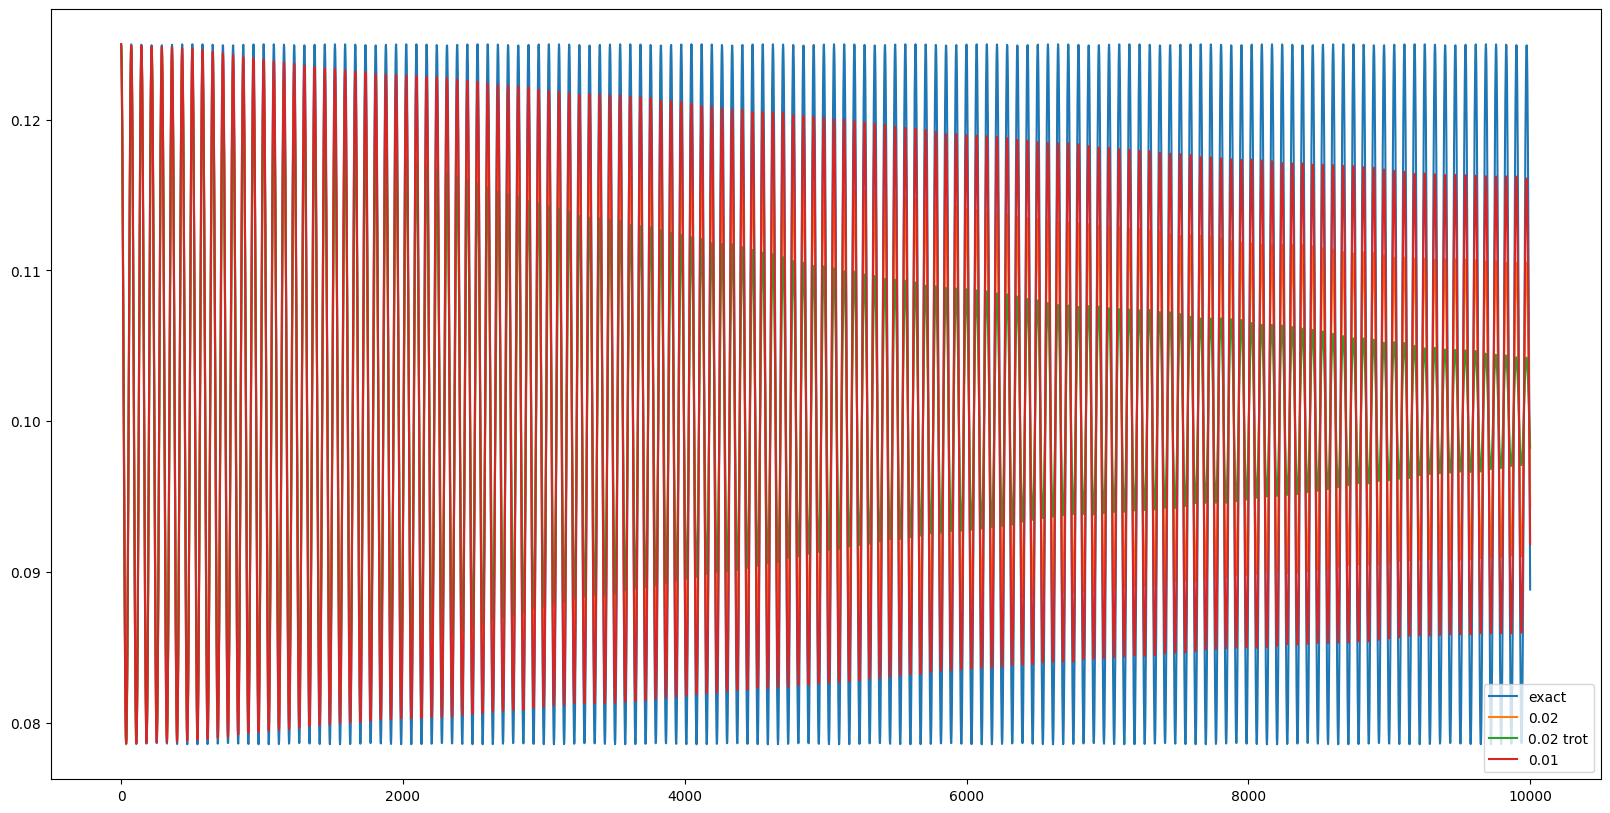

In [23]:
psi = np.array([1 / math.sqrt(8) for i in range(8)])
V_diag = np.array([1, 0, 0, 0, 0, 0, 0, 0])
# data_002 = complete_get_statevector_no_trotter(3,psi,1,0.02,1/math.sqrt(2),V_diag,5000,1024*8)

# data_002_trot = complete_get_statevector(3,psi,1,0.02,1/math.sqrt(2),V_diag,5000,1024*8)

# data_001 = complete_get_statevector_no_trotter(3,psi,1,0.01,1/math.sqrt(2),V_diag,10000,1024*8)

# data_001_trot = complete_get_statevector(3,psi,1,0.01,1/math.sqrt(2),V_diag,10000,1024*8)
exc = exact_complete(3, psi, 1, V_diag, 1, 100, 0.02)[1]
plt.plot(np.arange(0, 10002, 2), exc[0][:-1])
plt.plot(np.arange(0, 10002, 2), np.abs(data_002[0]) ** 2)
plt.plot(np.arange(0, 10002, 2), np.abs(data_002_trot[:, 0]) ** 2)
plt.plot(np.abs(data_001[0]) ** 2)
# plt.plot(np.abs(data_001_trot[:,0])**2)

# for i in range(8):

#     plt.plot(exc[i])
# for i in range(len(exc[0])):
#     print(np.sum(exc[:,i]))

plt.legend(["exact", "0.02", "0.02 trot", "0.01", "0.01 trot"])
print(exc[1].shape)

# **Exact Solution (Complete Graph)**



In [6]:
from scipy.integrate import solve_ivp


def deriv(t, psi, gamma, numQubits, V, g):
    L = np.zeros(V.shape)
    for i in range(len(L)):
        for j in range(len(L)):
            L[i][j] = -(2**numQubits - 1) if i == j else 1
    K = np.diag(np.abs(psi) ** 2)
    psidot = np.matmul((-gamma * L + V - g * K) * (-1j), psi)
    psidot.tolist()
    return psidot


def exact_complete(numQubits, psi_init, gamma, V_diag, g, n, max_step):
    V = np.diag(V_diag)

    p = (gamma, numQubits, V, g)
    t0, tf = 0, n

    psi = tuple([complex(psi_init[i]) for i in range(len(psi_init))])
    soln = solve_ivp(deriv, (t0, tf), psi, args=p, max_step=max_step)

    for j in range(len(soln.y)):
        for i in range(len(soln.y[j])):
            soln.y[j][i] = np.absolute(soln.y[j][i]) ** 2  # |ψ|^2

    return soln.t, soln.y


def exact_complete_get_psi(numQubits, psi_init, gamma, V_diag, g, n, max_step):
    V = np.diag(V_diag)

    p = (gamma, numQubits, V, g)
    t0, tf = 0, n

    psi = tuple([complex(psi_init[i]) for i in range(len(psi_init))])
    soln = solve_ivp(deriv, (t0, tf), psi, args=p, max_step=max_step)

    return soln.t, soln.y

In [7]:
def compare(T, delta_t, N):
    psi = [1 / math.sqrt(8) for i in range(8)]
    V_diag = [1, 0, 0, 0, 0, 0, 0, 0]
    n = int(T / delta_t)
    data = np.zeros((N, n + 1))
    for i in range(N):
        print(str(i) + "/" + str(N))
        data[i] = (
            np.abs(
                complete_get_statevector_no_trotter(
                    3, psi, 1, delta_t, 1 / math.sqrt(2), V_diag, n, 1024 * 4
                )[0]
            )
            ** 2
        )
    mu_hat, stdev_hat = np.mean(data, axis=0), np.std(data, axis=0)
    # plt.plot(np.linspace(0,len(exact_data[1][0])-1,n+1),mu_hat)
    # plt.plot(exact_data[1][0])
    # plt.legend(['simulation','exact'])
    # plt.show()
    return mu_hat, stdev_hat

In [35]:
# psi = [1/math.sqrt(8) for i in range(8)]
# V_diag = [1,0,0,0,0,0,0,0]
# data = np.abs(exact_complete(3,psi,1,V_diag,1,50,0.001)[1][0])**2
# plt.plot(data)
from scipy.signal import find_peaks


def get_period(data):
    # Assuming 'data' is your np array
    peaks, _ = find_peaks(data)

    # Check for at least 2 peaks to compute a period
    if len(peaks) > 1:
        period = peaks[1] - peaks[0]
    else:
        period = None
    return (peaks[-1] - peaks[0]) / (len(peaks) - 1)


def moving_avg(arr, window_size):
    num_values = len(arr) - window_size + 1

    # Create an empty array to store the moving average values
    avg = np.empty(num_values)

    # Compute the forward moving average
    for i in range(num_values):
        avg[i] = np.mean(arr[i : i + window_size])

    return avg

In [9]:
exact = np.load("exact.npy")
period_in_t = get_period(exact[0]) * 0.001
period_in_t

0.7228321167883212

In [102]:
def fidelity(T, delta_t, max_N):
    psi = [1 / math.sqrt(8) for i in range(8)]
    V_diag = [1, 0, 0, 0, 0, 0, 0, 0]
    n = int(T / delta_t)
    exact_data = exact_complete_get_psi(3, psi, 1, V_diag, 1, T, max_step=delta_t)
    f = np.zeros(max_N)
    data = []
    for i in range(max_N):
        print(i)
        data.append(
            complete_get_statevector(
                3, psi, 1, delta_t, 1 / math.sqrt(2), V_diag, n, 1024 * 4
            )
        )
    f = np.zeros(max_N)
    avg = np.zeros((max_N, 8), dtype=complex)
    data = np.array(data)
    for i in range(1, max_N + 1):
        avg[i - 1][:] = np.mean(data[:i][:, -1], axis=0)
    for i in range(max_N):
        psi1 = avg[i]
        psi2 = exact_data[1][:, -1]
        f[i] = np.abs(np.dot(psi1.conj(), psi2)) ** 2
    return data, f


data, f = fidelity(T=50, delta_t=0.05, max_N=50)

0
0
100
200
300
400
500
600
700
800
900
1
0
100
200
300
400
500
600
700
800
900
2
0
100
200
300
400
500
600
700
800
900
3
0
100
200
300
400
500
600
700
800
900
4
0
100
200
300
400
500
600
700
800
900
5
0
100
200
300
400
500
600
700
800
900
6
0
100
200
300
400
500
600
700
800
900
7
0
100
200
300
400
500
600
700
800
900
8
0
100
200
300
400
500
600
700
800
900
9
0
100
200
300
400
500
600
700
800
900
10
0
100
200
300
400
500
600
700
800
900
11
0
100
200
300
400
500
600
700
800
900
12
0
100
200
300
400
500
600
700
800
900
13
0
100
200
300
400
500
600
700
800
900
14
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
16
0
100
200
300
400
500
600
700
800
900
17
0
100
200
300
400
500
600
700
800
900
18
0
100
200
300
400
500
600
700
800
900
19
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
21
0
100
200
300
400
500
600
700
800
900
22
0
100
200
300
400
500
600
700
800
900
23
0
100
200
300
400
500
600
700
800
900
24
0
100
200
300
400
500
6

# $f(t,\Delta t,N)=\frac{|\mu(t)-\hat{\mu}(t)|}{\hat{\sigma}(t)/\sqrt{N}}$

In [10]:
def f(T, delta_t, N):
    mu_hat, stdev_hat = compare(T, delta_t, N)
    err = np.zeros_like(mu_hat)
    exact_t = np.load("exact_t.npy")
    exact = np.load("exact.npy")
    exact_plot = []
    exact_plot_t = []
    for i in range(2, len(err)):
        t = round(i * delta_t, 3)
        exact_plot_t.append(t)
        err[i] = np.abs(exact[0][int(t / 0.001)] - mu_hat[i]) / (
            stdev_hat[i] / np.sqrt(N)
        )
        exact_plot.append(exact[0][int(t / 0.001)])
    # plt.plot(exact_plot_t,exact_plot)
    # plt.plot(exact_plot_t,mu_hat[2:])
    # plt.legend(['exact','muhat'])
    # plt.show()
    plt.plot(np.linspace(0, T, len(err))[2:], err[2:])
    plt.xlabel("time")
    plt.ylabel("f")
    plt.savefig("delta_t=" + str(round(delta_t, 3)) + ".png")
    plt.show()

    return err

0/50
0
100
200
300
400
500
1/50
0
100
200
300
400
500
2/50
0
100
200
300
400
500
3/50
0
100
200
300
400
500
4/50
0
100
200
300
400
500
5/50
0
100
200
300
400
500
6/50
0
100
200
300
400
500
7/50
0
100
200
300
400
500
8/50
0
100
200
300
400
500
9/50
0
100
200
300
400
500
10/50
0
100
200
300
400
500
11/50
0
100
200
300
400
500
12/50
0
100
200
300
400
500
13/50
0
100
200
300
400
500
14/50
0
100
200
300
400
500
15/50
0
100
200
300
400
500
16/50
0
100
200
300
400
500
17/50
0
100
200
300
400
500
18/50
0
100
200
300
400
500
19/50
0
100
200
300
400
500
20/50
0
100
200
300
400
500
21/50
0
100
200
300
400
500
22/50
0
100
200
300
400
500
23/50
0
100
200
300
400
500
24/50
0
100
200
300
400
500
25/50
0
100
200
300
400
500
26/50
0
100
200
300
400
500
27/50
0
100
200
300
400
500
28/50
0
100
200
300
400
500
29/50
0
100
200
300
400
500
30/50
0
100
200
300
400
500
31/50
0
100
200
300
400
500
32/50
0
100
200
300
400
500
33/50
0
100
200
300
400
500
34/50
0
100
200
300
400
500
35/50
0
100
200
300
400
500
36

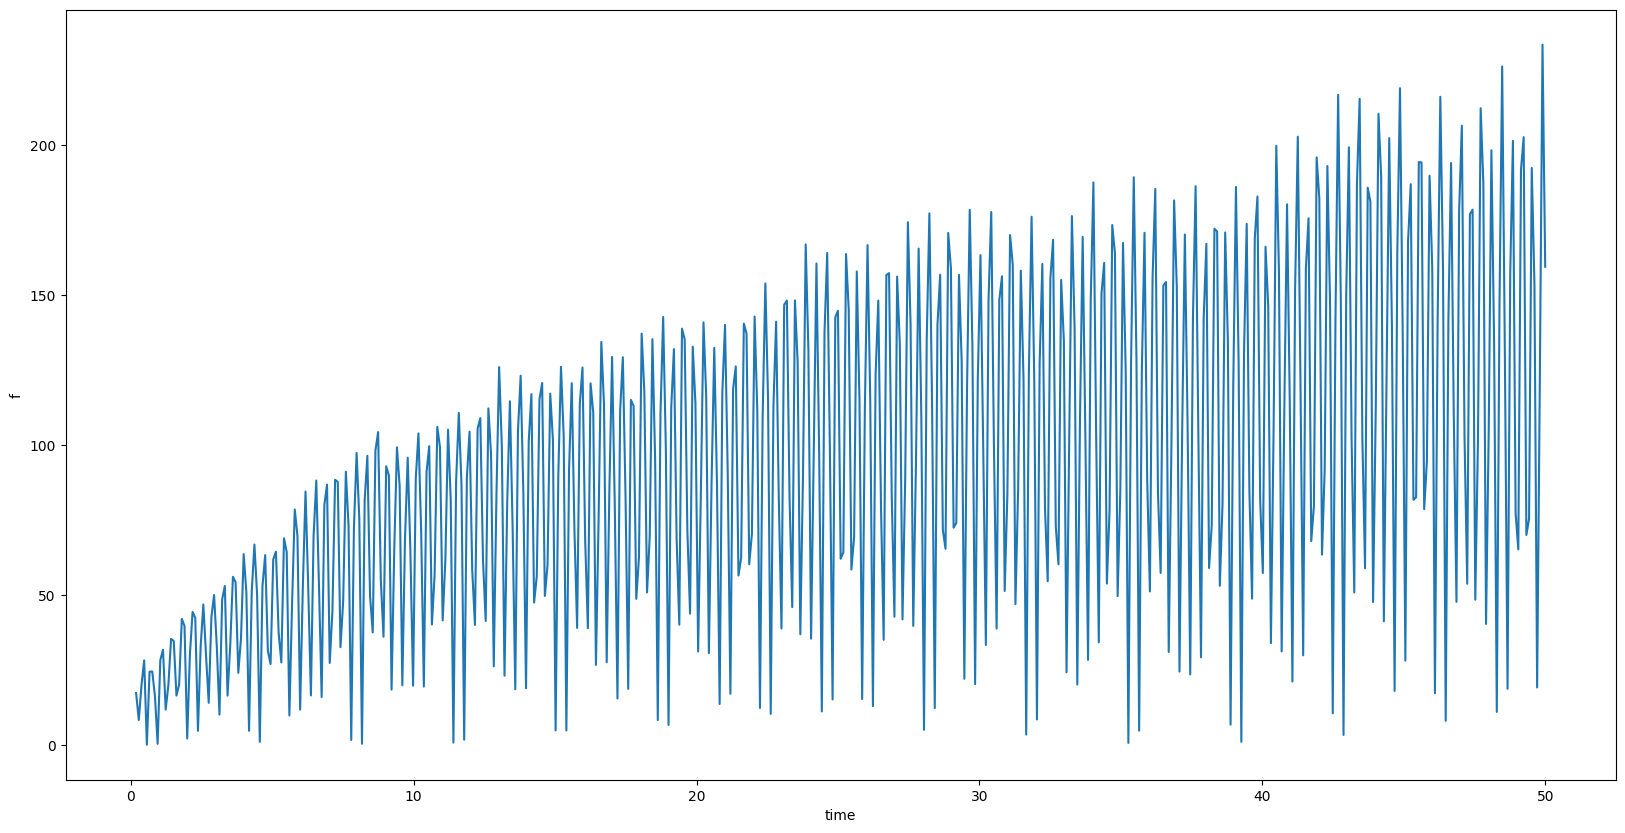

0/50
0
100
200
300
400
500
1/50
0
100
200
300
400
500
2/50
0
100
200
300
400
500
3/50
0
100
200
300
400
500
4/50
0
100
200
300
400
500
5/50
0
100
200
300
400
500
6/50
0
100
200
300
400
500
7/50
0
100
200
300
400
500
8/50
0
100
200
300
400
500
9/50
0
100
200
300
400
500
10/50
0
100
200
300
400
500
11/50
0
100
200
300
400
500
12/50
0
100
200
300
400
500
13/50
0
100
200
300
400
500
14/50
0
100
200
300
400
500
15/50
0
100
200
300
400
500
16/50
0
100
200
300
400
500
17/50
0
100
200
300
400
500
18/50
0
100
200
300
400
500
19/50
0
100
200
300
400
500
20/50
0
100
200
300
400
500
21/50
0
100
200
300
400
500
22/50
0
100
200
300
400
500
23/50
0
100
200
300
400
500
24/50
0
100
200
300
400
500
25/50
0
100
200
300
400
500
26/50
0
100
200
300
400
500
27/50
0
100
200
300
400
500
28/50
0
100
200
300
400
500
29/50
0
100
200
300
400
500
30/50
0
100
200
300
400
500
31/50
0
100
200
300
400
500
32/50
0
100
200
300
400
500
33/50
0
100
200
300
400
500
34/50
0
100
200
300
400
500
35/50
0
100
200
300
400
500
36

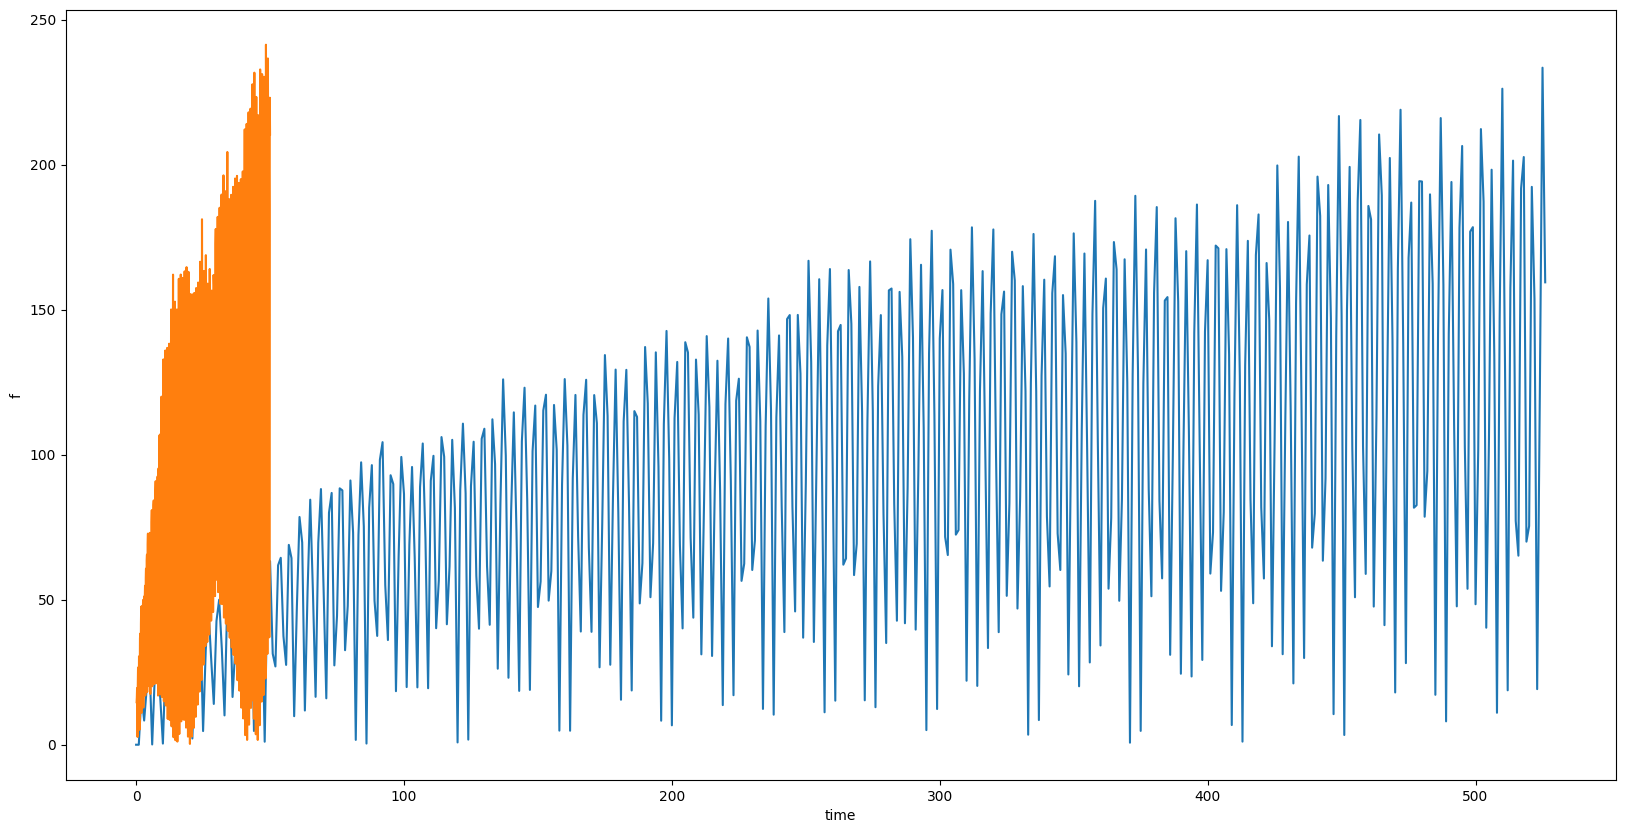

0/50
0
100
200
300
400
500
1/50
0
100
200
300
400
500
2/50
0
100
200
300
400
500
3/50
0
100
200
300
400
500
4/50
0
100
200
300
400
500
5/50
0
100
200
300
400
500
6/50
0
100
200
300
400
500
7/50
0
100
200
300
400
500
8/50
0
100
200
300
400
500
9/50
0
100
200
300
400
500
10/50
0
100
200
300
400
500
11/50
0
100
200
300
400
500
12/50
0
100
200
300
400
500
13/50
0
100
200
300
400
500
14/50
0
100
200
300
400
500
15/50
0
100
200
300
400
500
16/50
0
100
200
300
400
500
17/50
0
100
200
300
400
500
18/50
0
100
200
300
400
500
19/50
0
100
200
300
400
500
20/50
0
100
200
300
400
500
21/50
0
100
200
300
400
500
22/50
0
100
200
300
400
500
23/50
0
100
200
300
400
500
24/50
0
100
200
300
400
500
25/50
0
100
200
300
400
500
26/50
0
100
200
300
400
500
27/50
0
100
200
300
400
500
28/50
0
100
200
300
400
500
29/50
0
100
200
300
400
500
30/50
0
100
200
300
400
500
31/50
0
100
200
300
400
500
32/50
0
100
200
300
400
500
33/50
0
100
200
300
400
500
34/50
0
100
200
300
400
500
35/50
0
100
200
300
400
500
36

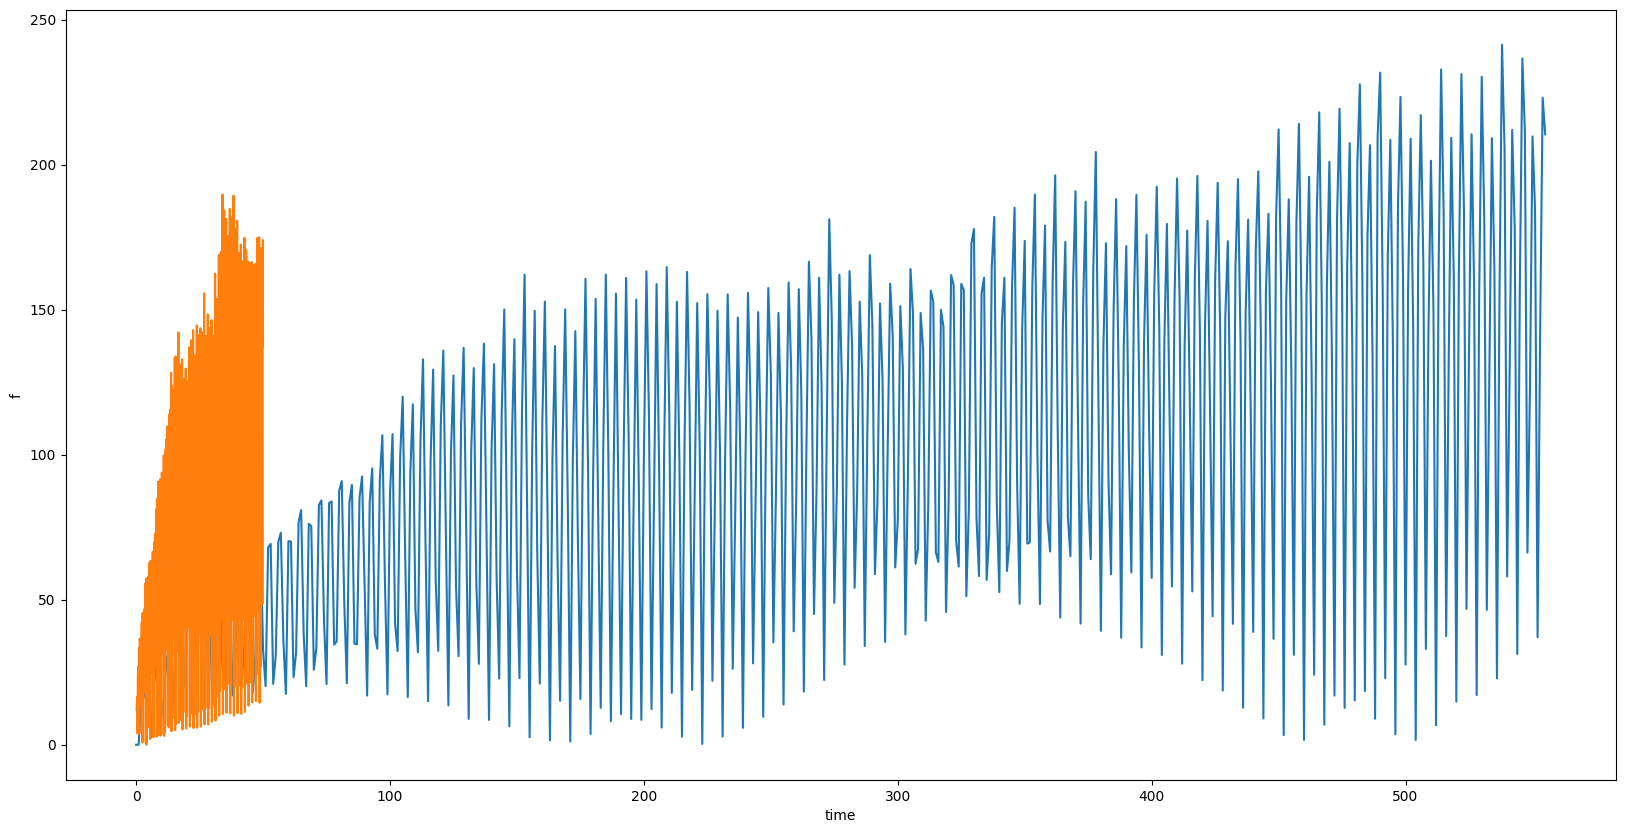

0/50
0
100
200
300
400
500
600
1/50
0
100
200
300
400
500
600
2/50
0
100
200
300
400
500
600
3/50
0
100
200
300
400
500
600
4/50
0
100
200
300
400
500
600
5/50
0
100
200
300
400
500
600
6/50
0
100
200
300
400
500
600
7/50
0
100
200
300
400
500
600
8/50
0
100
200
300
400
500
600
9/50
0
100
200
300
400
500
600
10/50
0
100
200
300
400
500
600
11/50
0
100
200
300
400
500
600
12/50
0
100
200
300
400
500
600
13/50
0
100
200
300
400
500
600
14/50
0
100
200
300
400
500
600
15/50
0
100
200
300
400
500
600
16/50
0
100
200
300
400
500
600
17/50
0
100
200
300
400
500
600
18/50
0
100
200
300
400
500
600
19/50
0
100
200
300
400
500
600
20/50
0
100
200
300
400
500
600
21/50
0
100
200
300
400
500
600
22/50
0
100
200
300
400
500
600
23/50
0
100
200
300
400
500
600
24/50
0
100
200
300
400
500
600
25/50
0
100
200
300
400
500
600
26/50
0
100
200
300
400
500
600
27/50
0
100
200
300
400
500
600
28/50
0
100
200
300
400
500
600
29/50
0
100
200
300
400
500
600
30/50
0
100
200
300
400
500
600
31/50
0
100
200
30

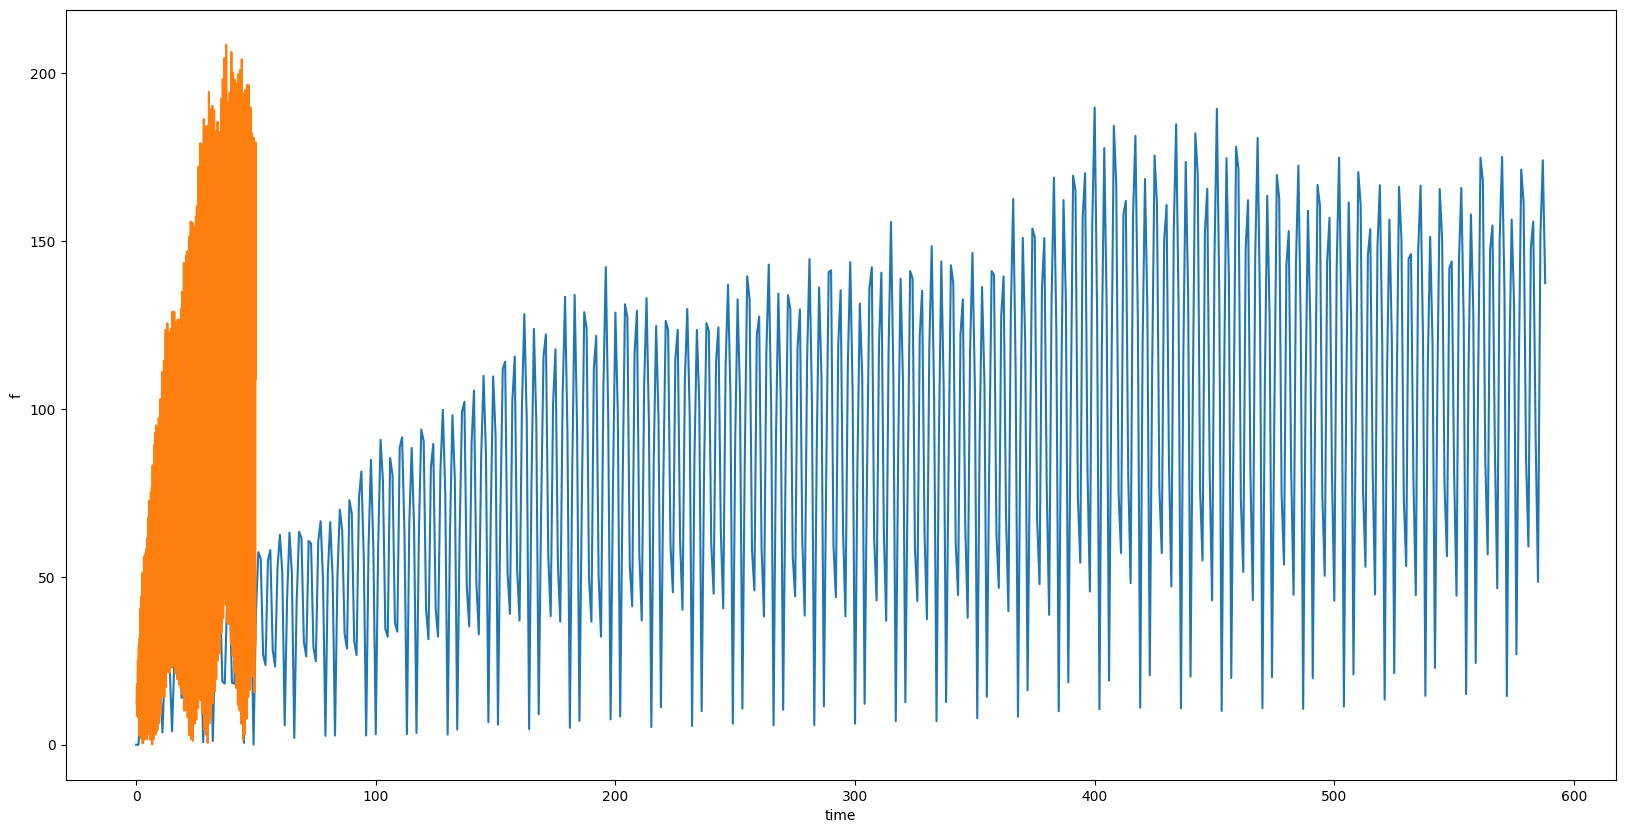

0/50
0
100
200
300
400
500
600
1/50
0
100
200
300
400
500
600
2/50
0
100
200
300
400
500
600
3/50
0
100
200
300
400
500
600
4/50
0
100
200
300
400
500
600
5/50
0
100
200
300
400
500
600
6/50
0
100
200
300
400
500
600
7/50
0
100
200
300
400
500
600
8/50
0
100
200
300
400
500
600
9/50
0
100
200
300
400
500
600
10/50
0
100
200
300
400
500
600
11/50
0
100
200
300
400
500
600
12/50
0
100
200
300
400
500
600
13/50
0
100
200
300
400
500
600
14/50
0
100
200
300
400
500
600
15/50
0
100
200
300
400
500
600
16/50
0
100
200
300
400
500
600
17/50
0
100
200
300
400
500
600
18/50
0
100
200
300
400
500
600
19/50
0
100
200
300
400
500
600
20/50
0
100
200
300
400
500
600
21/50
0
100
200
300
400
500
600
22/50
0
100
200
300
400
500
600
23/50
0
100
200
300
400
500
600
24/50
0
100
200
300
400
500
600
25/50
0
100
200
300
400
500
600
26/50
0
100
200
300
400
500
600
27/50
0
100
200
300
400
500
600
28/50
0
100
200
300
400
500
600
29/50
0
100
200
300
400
500
600
30/50
0
100
200
300
400
500
600
31/50
0
100
200
30

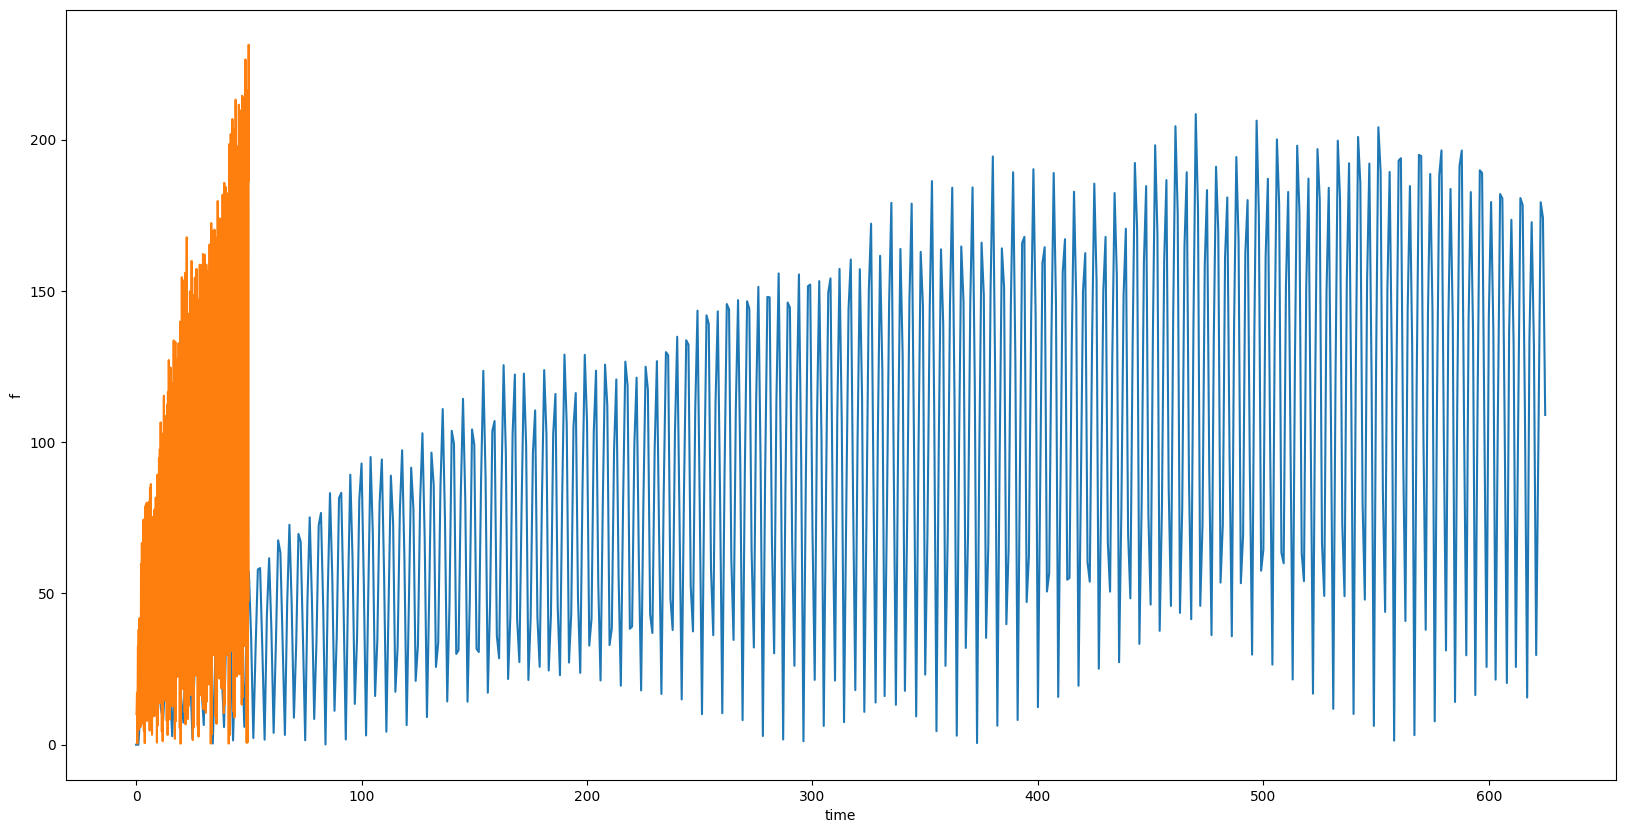

0/50
0
100
200
300
400
500
600
700
1/50
0
100
200
300
400
500
600
700
2/50
0
100
200
300
400
500
600
700
3/50
0
100
200
300
400
500
600
700
4/50
0
100
200
300
400
500
600
700
5/50
0
100
200
300
400
500
600
700
6/50
0
100
200
300
400
500
600
700
7/50
0
100
200
300
400
500
600
700
8/50
0
100
200
300
400
500
600
700
9/50
0
100
200
300
400
500
600
700
10/50
0
100
200
300
400
500
600
700
11/50
0
100
200
300
400
500
600
700
12/50
0
100
200
300
400
500
600
700
13/50
0
100
200
300
400
500
600
700
14/50
0
100
200
300
400
500
600
700
15/50
0
100
200
300
400
500
600
700
16/50
0
100
200
300
400
500
600
700
17/50
0
100
200
300
400
500
600
700
18/50
0
100
200
300
400
500
600
700
19/50
0
100
200
300
400
500
600
700
20/50
0
100
200
300
400
500
600
700
21/50
0
100
200
300
400
500
600
700
22/50
0
100
200
300
400
500
600
700
23/50
0
100
200
300
400
500
600
700
24/50
0
100
200
300
400
500
600
700
25/50
0
100
200
300
400
500
600
700
26/50
0
100
200
300
400
500
600
700
27/50
0
100
200
300
400
500
600
700
28

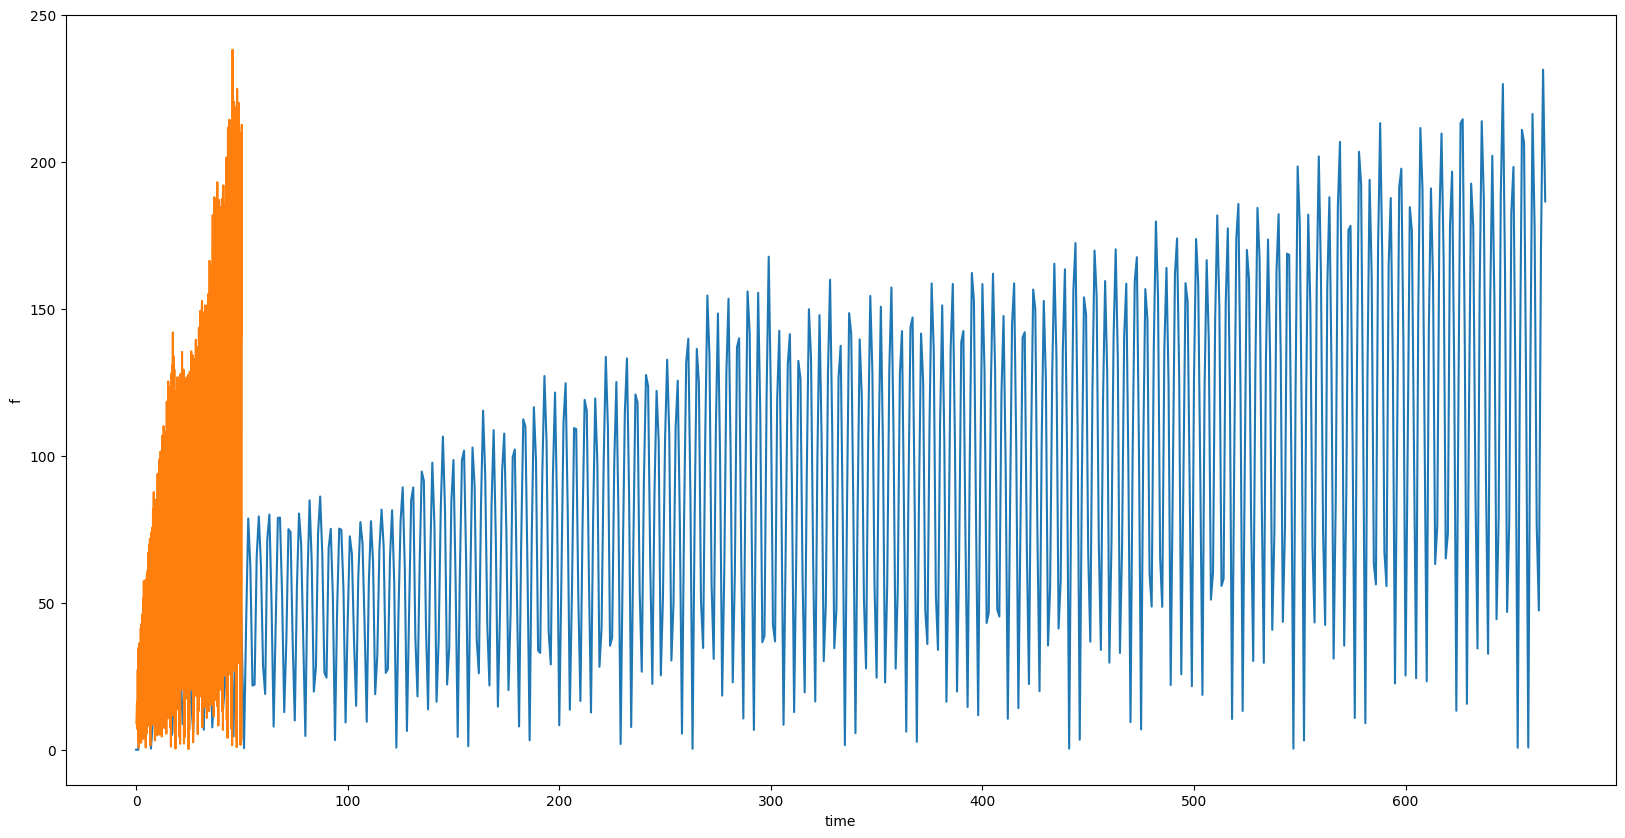

0/50
0
100
200
300
400
500
600
700
1/50
0
100
200
300
400
500
600
700
2/50
0
100
200
300
400
500
600
700
3/50
0
100
200
300
400
500
600
700
4/50
0
100
200
300
400
500
600
700
5/50
0
100
200
300
400
500
600
700
6/50
0
100
200
300
400
500
600
700
7/50
0
100
200
300
400
500
600
700
8/50
0
100
200
300
400
500
600
700
9/50
0
100
200
300
400
500
600
700
10/50
0
100
200
300
400
500
600
700
11/50
0
100
200
300
400
500
600
700
12/50
0
100
200
300
400
500
600
700
13/50
0
100
200
300
400
500
600
700
14/50
0
100
200
300
400
500
600
700
15/50
0
100
200
300
400
500
600
700
16/50
0
100
200
300
400
500
600
700
17/50
0
100
200
300
400
500
600
700
18/50
0
100
200
300
400
500
600
700
19/50
0
100
200
300
400
500
600
700
20/50
0
100
200
300
400
500
600
700
21/50
0
100
200
300
400
500
600
700
22/50
0
100
200
300
400
500
600
700
23/50
0
100
200
300
400
500
600
700
24/50
0
100
200
300
400
500
600
700
25/50
0
100
200
300
400
500
600
700
26/50
0
100
200
300
400
500
600
700
27/50
0
100
200
300
400
500
600
700
28

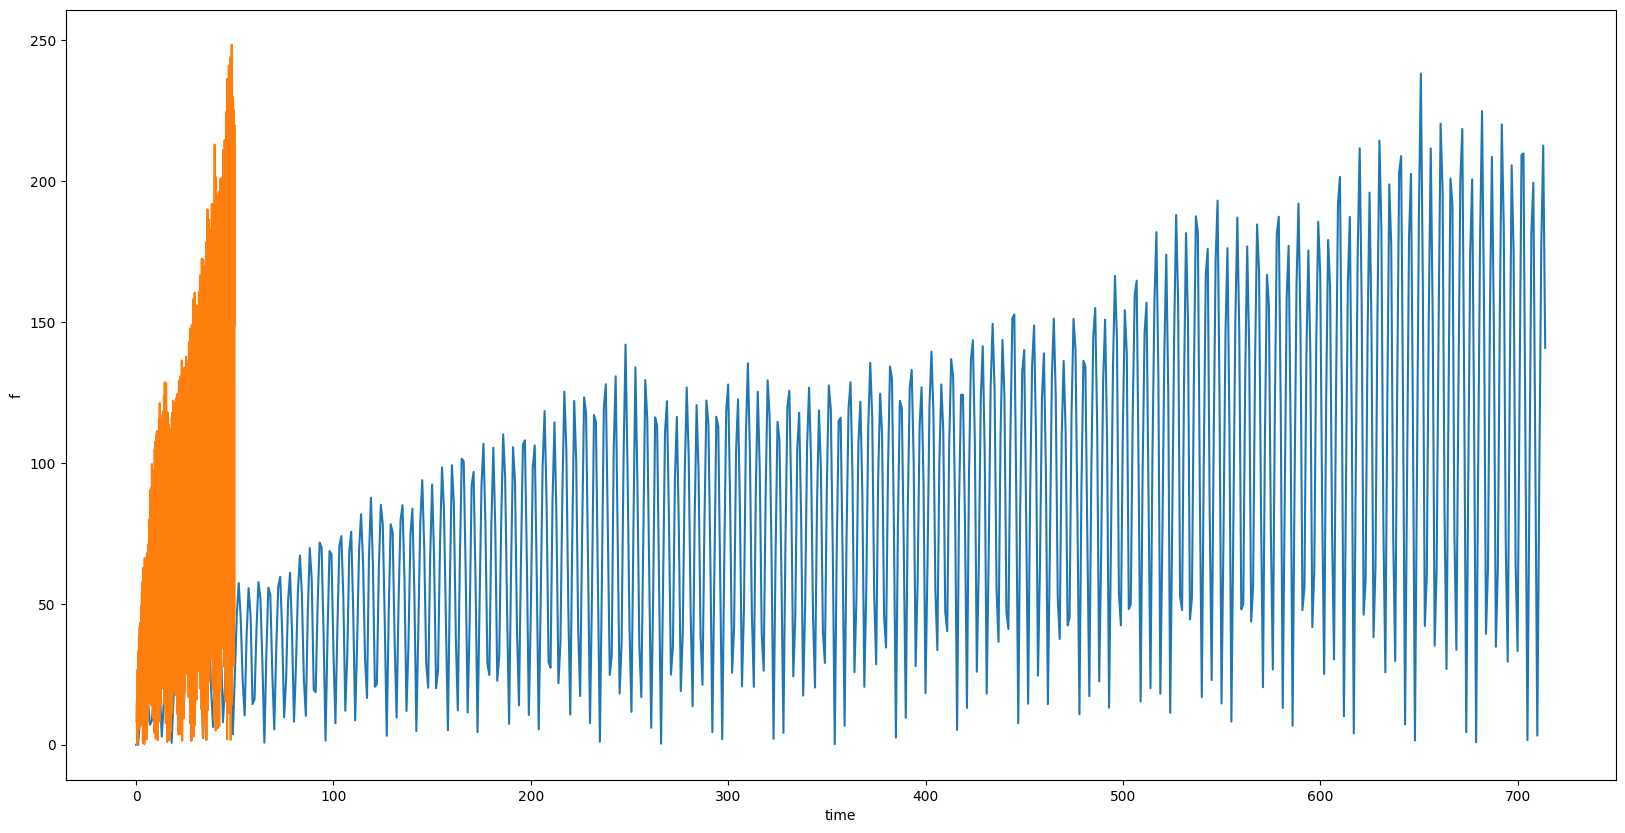

0/50
0
100
200
300
400
500
600
700
800
1/50
0
100
200
300
400
500
600
700
800
2/50
0
100
200
300
400
500
600
700
800
3/50
0
100
200
300
400
500
600
700
800
4/50
0
100
200
300
400
500
600
700
800
5/50
0
100
200
300
400
500
600
700
800
6/50
0
100
200
300
400
500
600
700
800
7/50
0
100
200
300
400
500
600
700
800
8/50
0
100
200
300
400
500
600
700
800
9/50
0
100
200
300
400
500
600
700
800
10/50
0
100
200
300
400
500
600
700
800
11/50
0
100
200
300
400
500
600
700
800
12/50
0
100
200
300
400
500
600
700
800
13/50
0
100
200
300
400
500
600
700
800
14/50
0
100
200
300
400
500
600
700
800
15/50
0
100
200
300
400
500
600
700
800
16/50
0
100
200
300
400
500
600
700
800
17/50
0
100
200
300
400
500
600
700
800
18/50
0
100
200
300
400
500
600
700
800
19/50
0
100
200
300
400
500
600
700
800
20/50
0
100
200
300
400
500
600
700
800
21/50
0
100
200
300
400
500
600
700
800
22/50
0
100
200
300
400
500
600
700
800
23/50
0
100
200
300
400
500
600
700
800
24/50
0
100
200
300
400
500
600
700
800
25/50
0
10

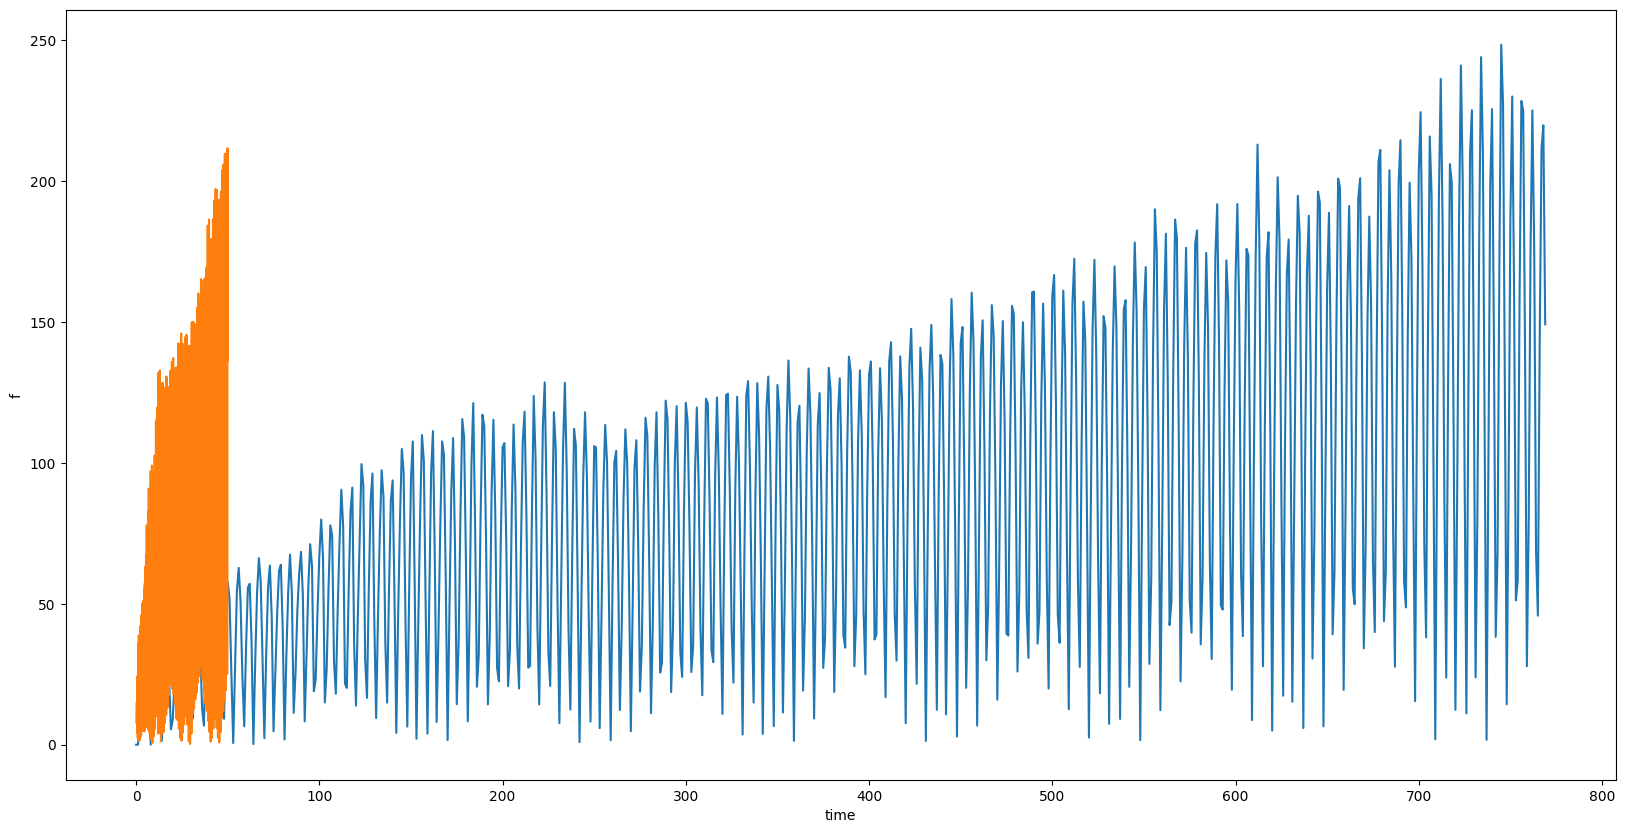

0/50
0
100
200
300
400
500
600
700
800
900
1/50
0
100
200
300
400
500
600
700
800
900
2/50
0
100
200
300
400
500
600
700
800
900
3/50
0
100
200
300
400
500
600
700
800
900
4/50
0
100
200
300
400
500
600
700
800
900
5/50
0
100
200
300
400
500
600
700
800
900
6/50
0
100
200
300
400
500
600
700
800
900
7/50
0
100
200
300
400
500
600
700
800
900
8/50
0
100
200
300
400
500
600
700
800
900
9/50
0
100
200
300
400
500
600
700
800
900
10/50
0
100
200
300
400
500
600
700
800
900
11/50
0
100
200
300
400
500
600
700
800
900
12/50
0
100
200
300
400
500
600
700
800
900
13/50
0
100
200
300
400
500
600
700
800
900
14/50
0
100
200
300
400
500
600
700
800
900
15/50
0
100
200
300
400
500
600
700
800
900
16/50
0
100
200
300
400
500
600
700
800
900
17/50
0
100
200
300
400
500
600
700
800
900
18/50
0
100
200
300
400
500
600
700
800
900
19/50
0
100
200
300
400
500
600
700
800
900
20/50
0
100
200
300
400
500
600
700
800
900
21/50
0
100
200
300
400
500
600
700
800
900
22/50
0
100
200
300
400
500
600
700
800
90

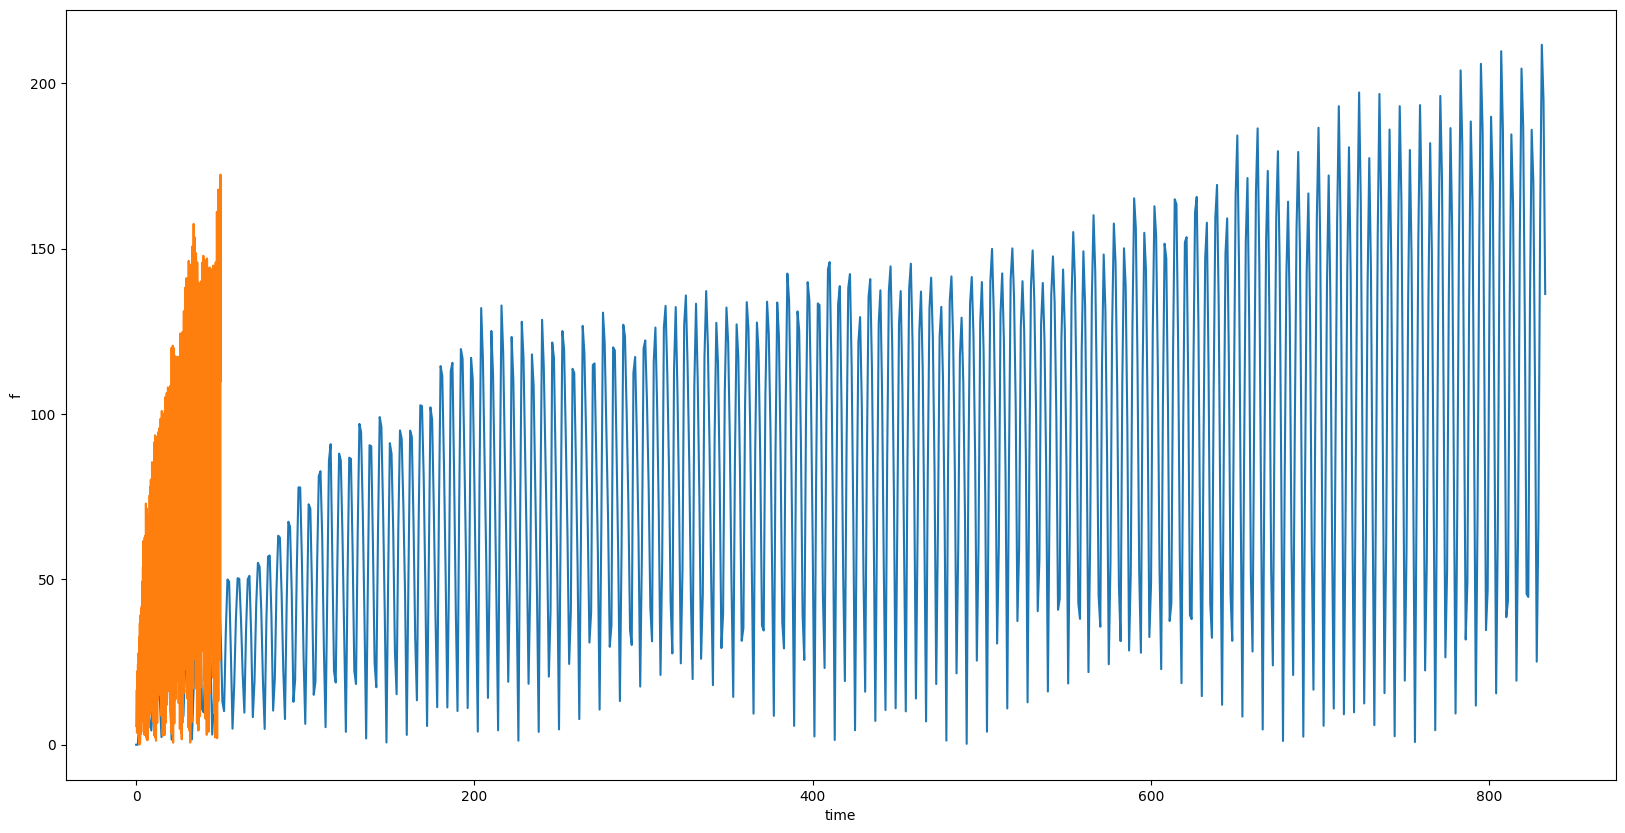

0/50
0
100
200
300
400
500
600
700
800
900
1/50
0
100
200
300
400
500
600
700
800
900
2/50
0
100
200
300
400
500
600
700
800
900
3/50
0
100
200
300
400
500
600
700
800
900
4/50
0
100
200
300
400
500
600
700
800
900
5/50
0
100
200
300
400
500
600
700
800
900
6/50
0
100
200
300
400
500
600
700
800
900
7/50
0
100
200
300
400
500
600
700
800
900
8/50
0
100
200
300
400
500
600
700
800
900
9/50
0
100
200
300
400
500
600
700
800
900
10/50
0
100
200
300
400
500
600
700
800
900
11/50
0
100
200
300
400
500
600
700
800
900
12/50
0
100
200
300
400
500
600
700
800
900
13/50
0
100
200
300
400
500
600
700
800
900
14/50
0
100
200
300
400
500
600
700
800
900
15/50
0
100
200
300
400
500
600
700
800
900
16/50
0
100
200
300
400
500
600
700
800
900
17/50
0
100
200
300
400
500
600
700
800
900
18/50
0
100
200
300
400
500
600
700
800
900
19/50
0
100
200
300
400
500
600
700
800
900
20/50
0
100
200
300
400
500
600
700
800
900
21/50
0
100
200
300
400
500
600
700
800
900
22/50
0
100
200
300
400
500
600
700
800
90

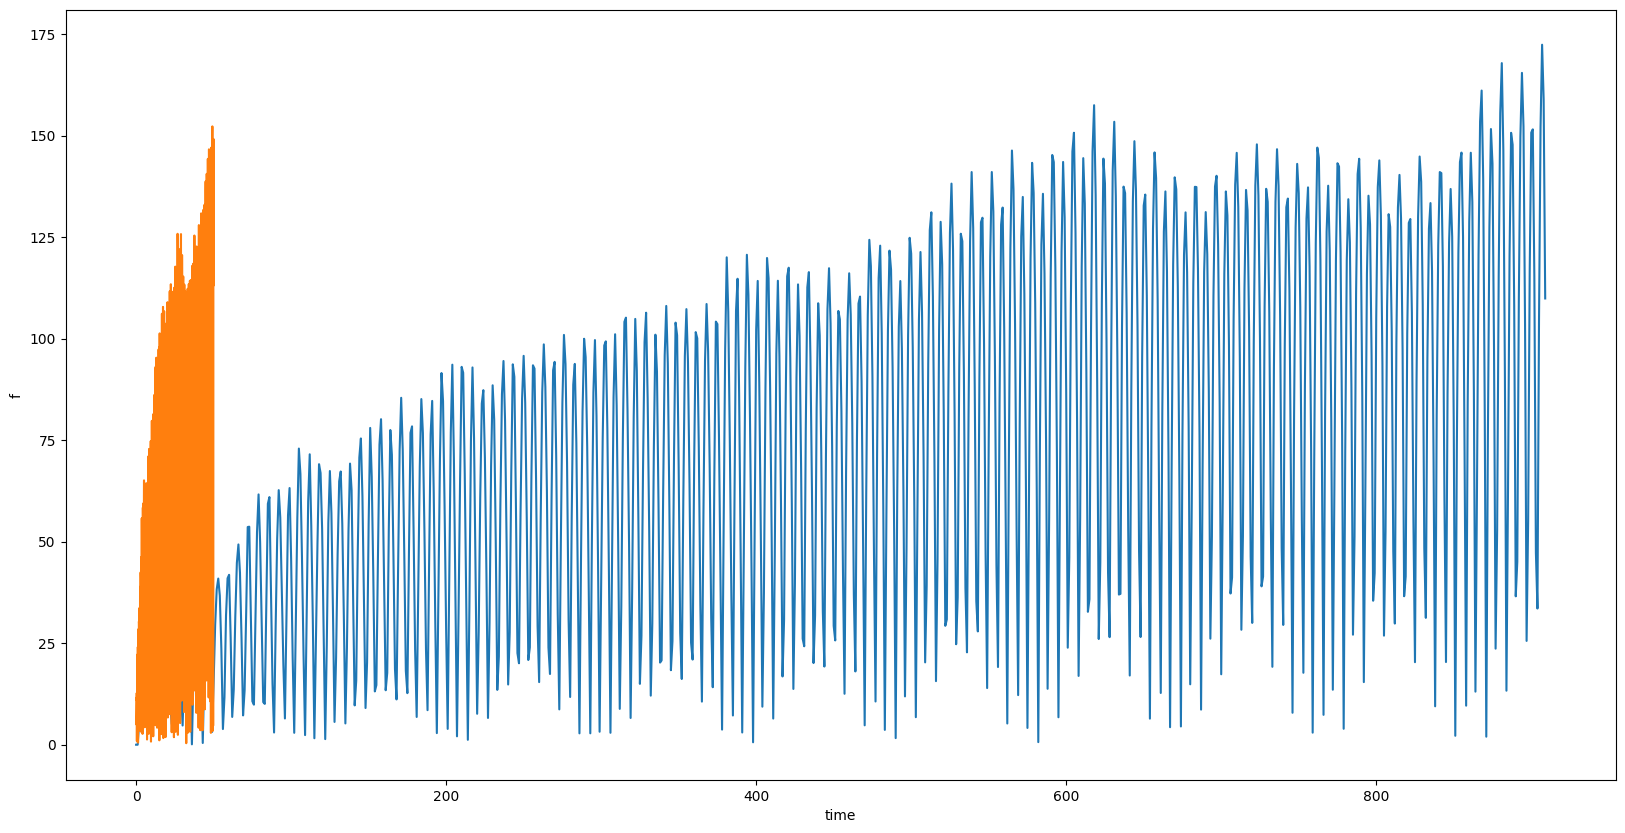

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
9/50
0
100
200
300
400
500
600
700
800
900
1000
1100
10/50
0
100
200
300
400
500
600
700
800
900
1000
1100
11/50
0
100
200
300
400
500
600
700
800
900
1000
1100
12/50
0
100
200
300
400
500
600
700
800
900
1000
1100
13/50
0
100
200
300
400
500
600
700
800
900
1000
1100
14/50
0
100
200
300
400
500
600
700
800
900
1000
1100
15/50
0
100
200
300
400
500
600
700
800
900
1000
1100
16/50
0
100
200
300
400
500
600
700
800
900
1000
1100
17/50
0
100
200
300
400
500
600
700
800
900
1000
1100
18/50
0
100
200
300
400
500
600
700
80

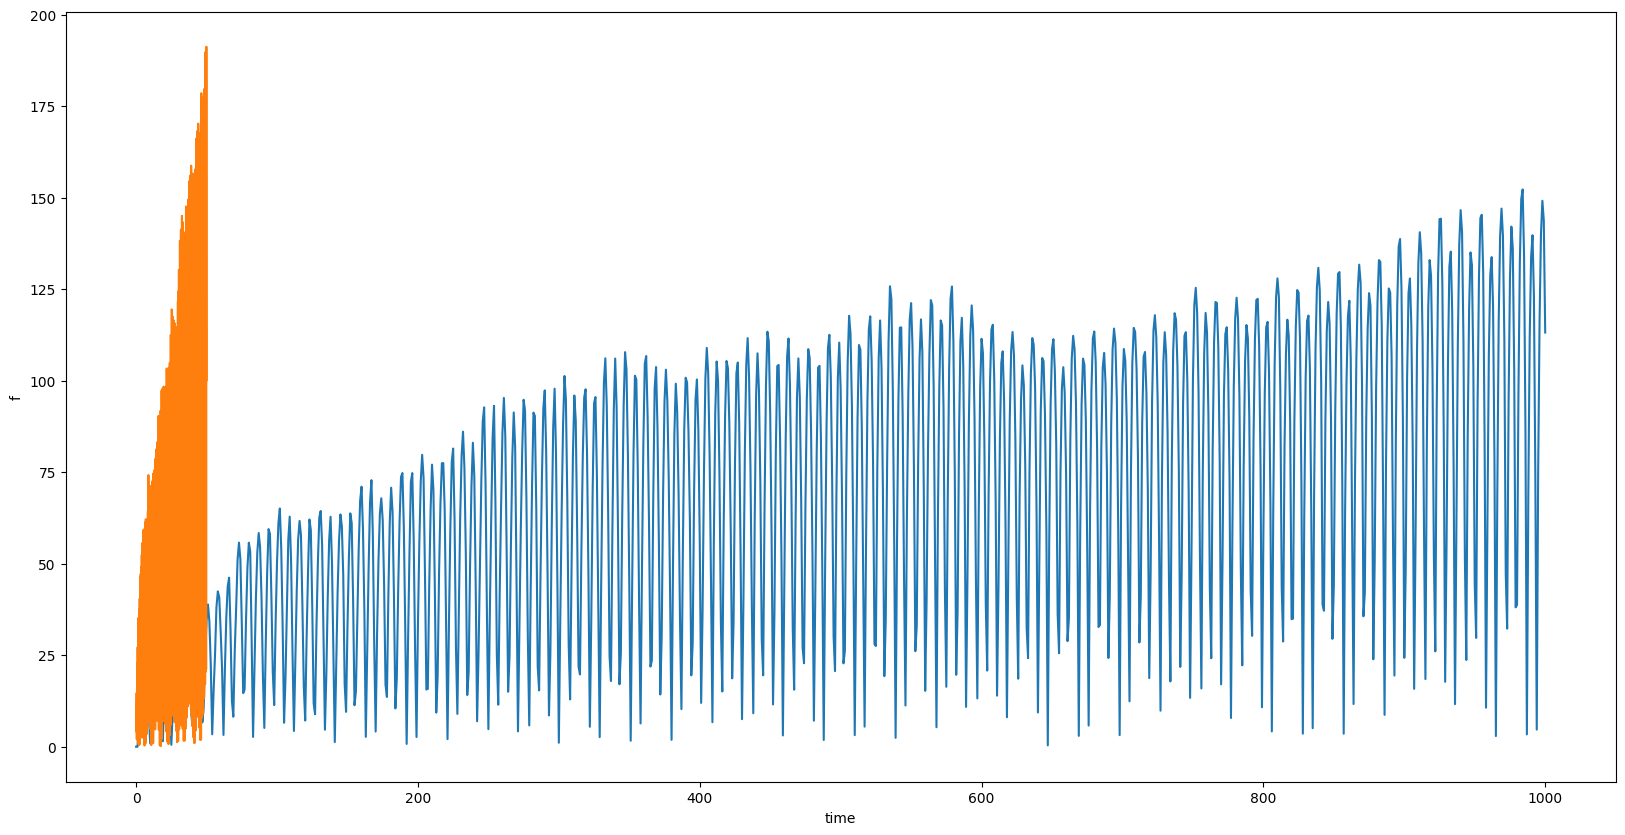

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
9/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
10/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
11/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
12/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
13/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
14/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
15/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
16/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
17/50
0

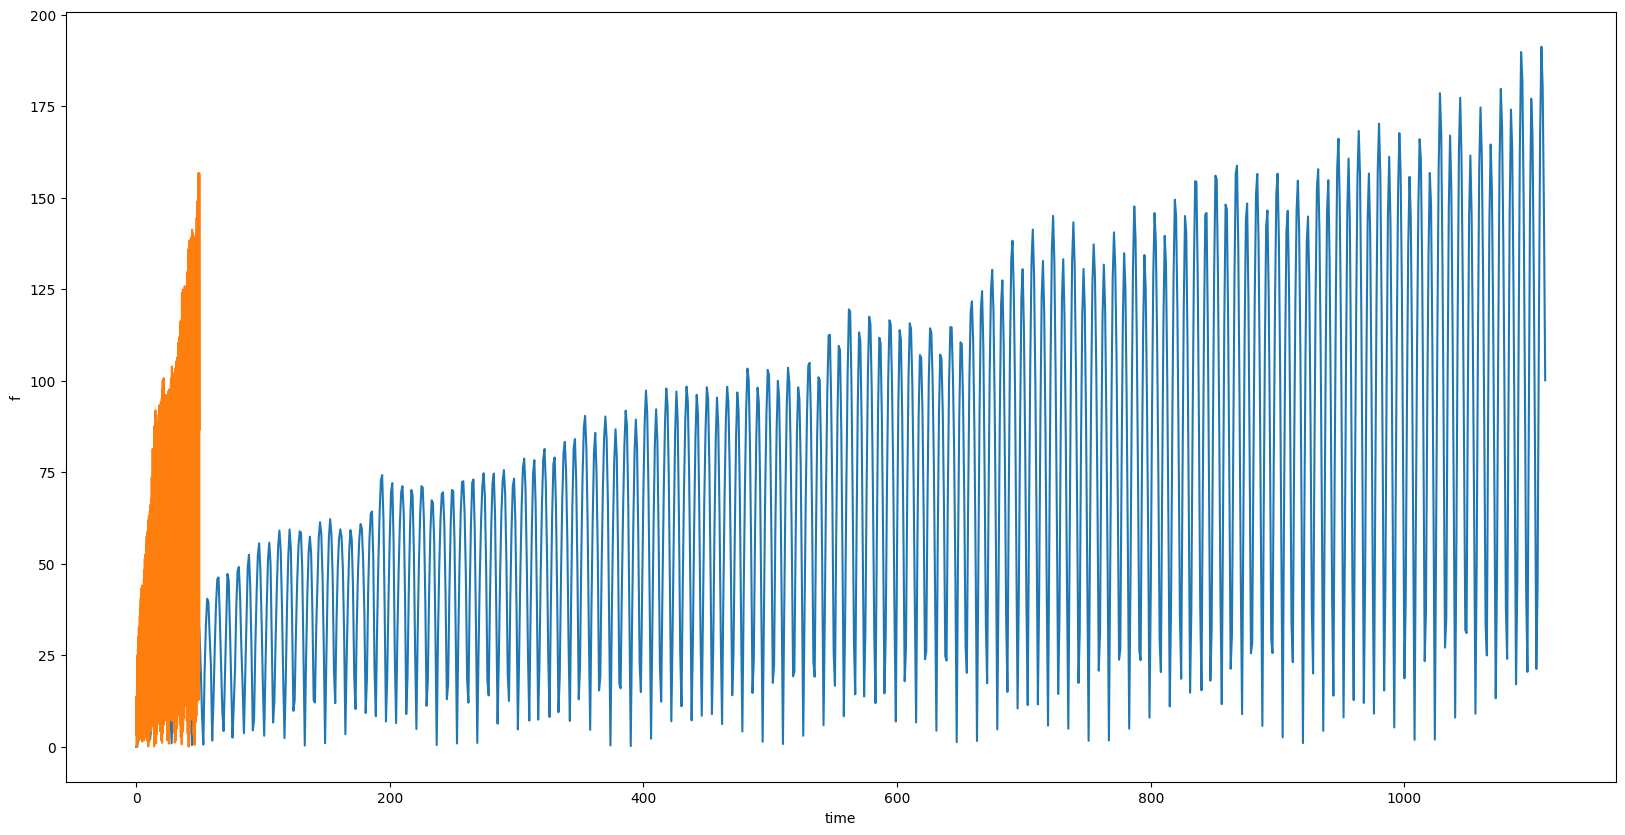

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
9/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
10/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
11/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
12/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
13/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
14/50
0
100
200
300
400
500
600
700
800
900


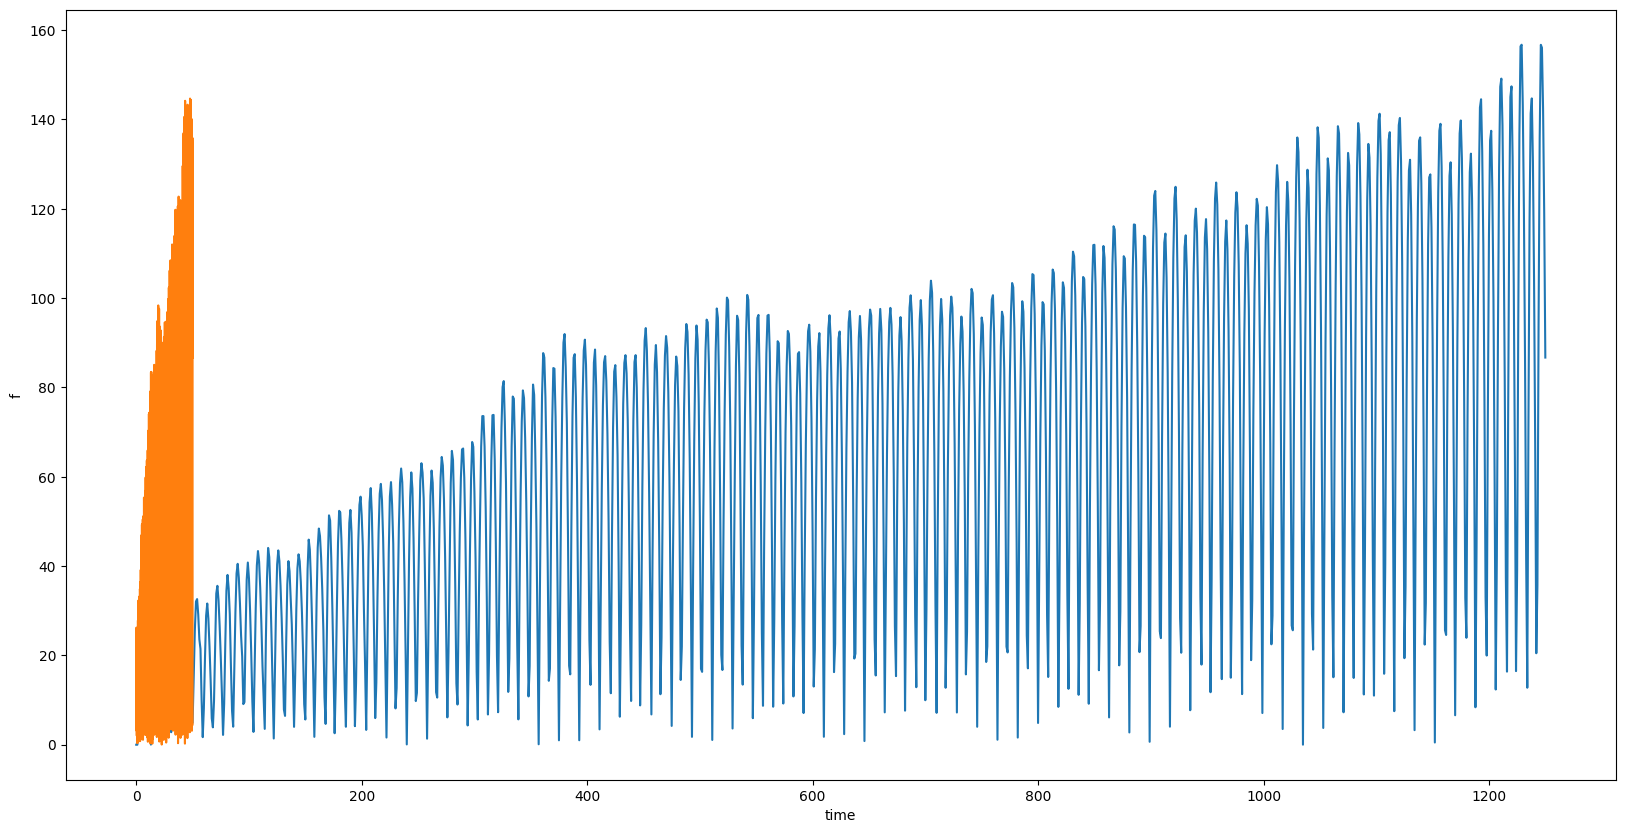

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
9/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
10/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
11/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
12/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
130

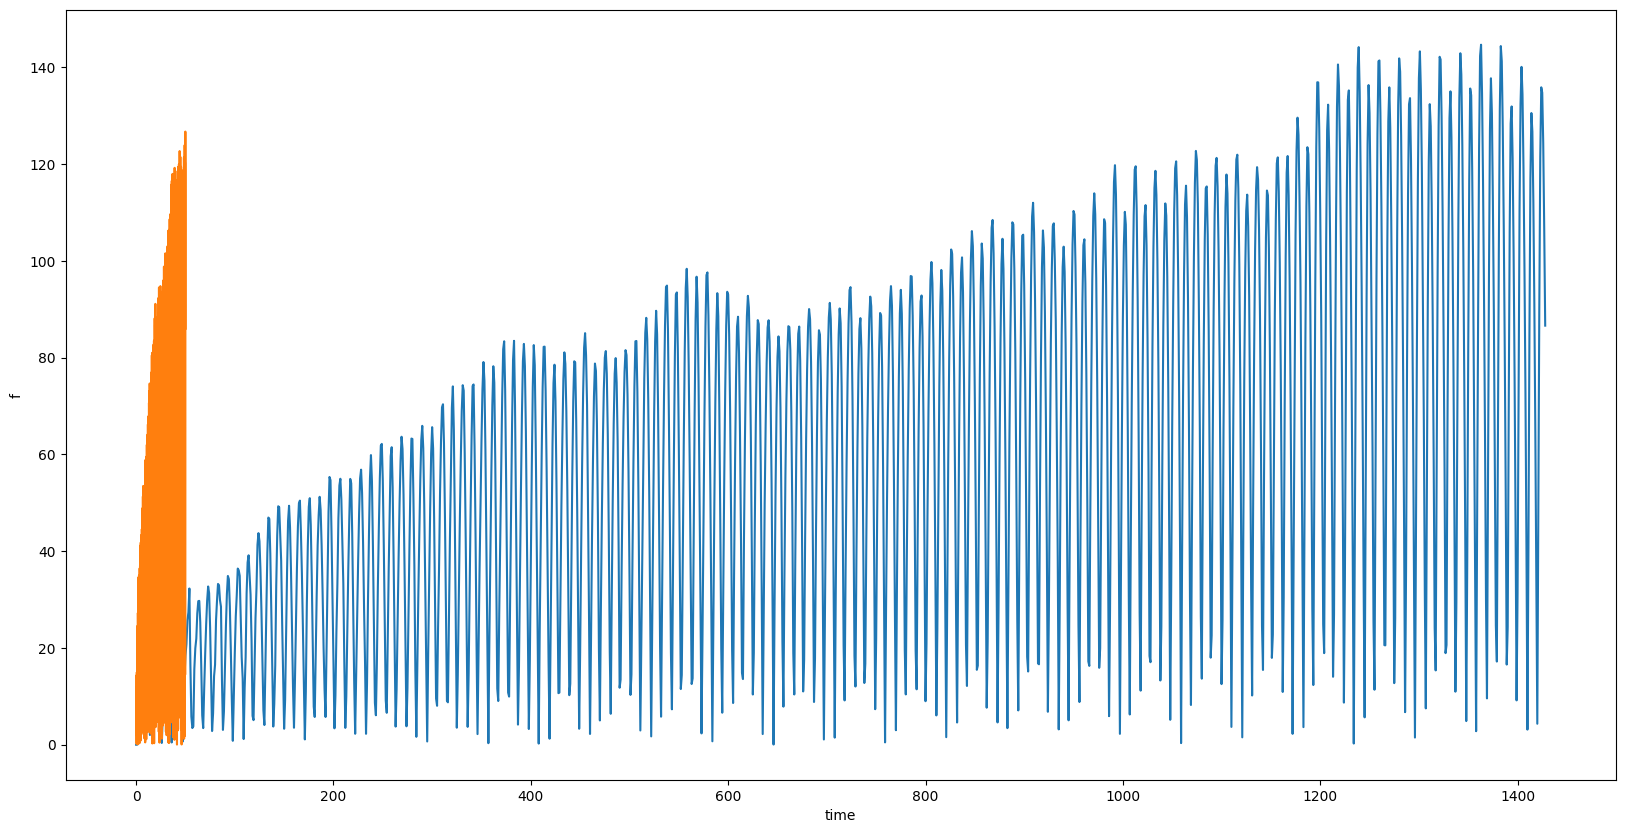

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
9/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
10/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1

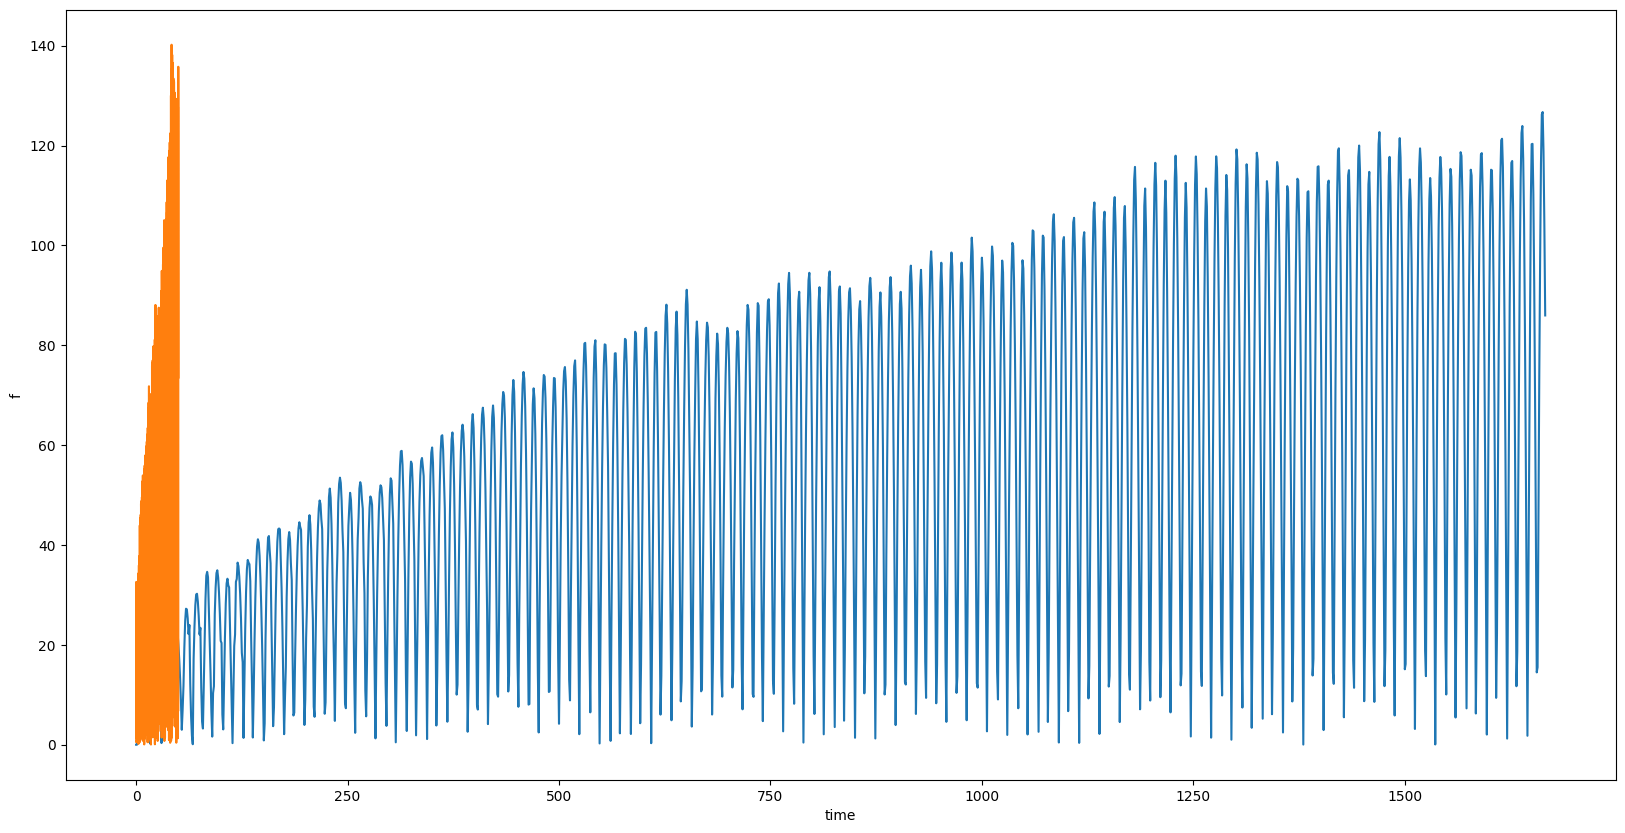

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
6/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
7/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
8/50
0
100
200
300
400
500
600
700
800
900
1000
1100
120

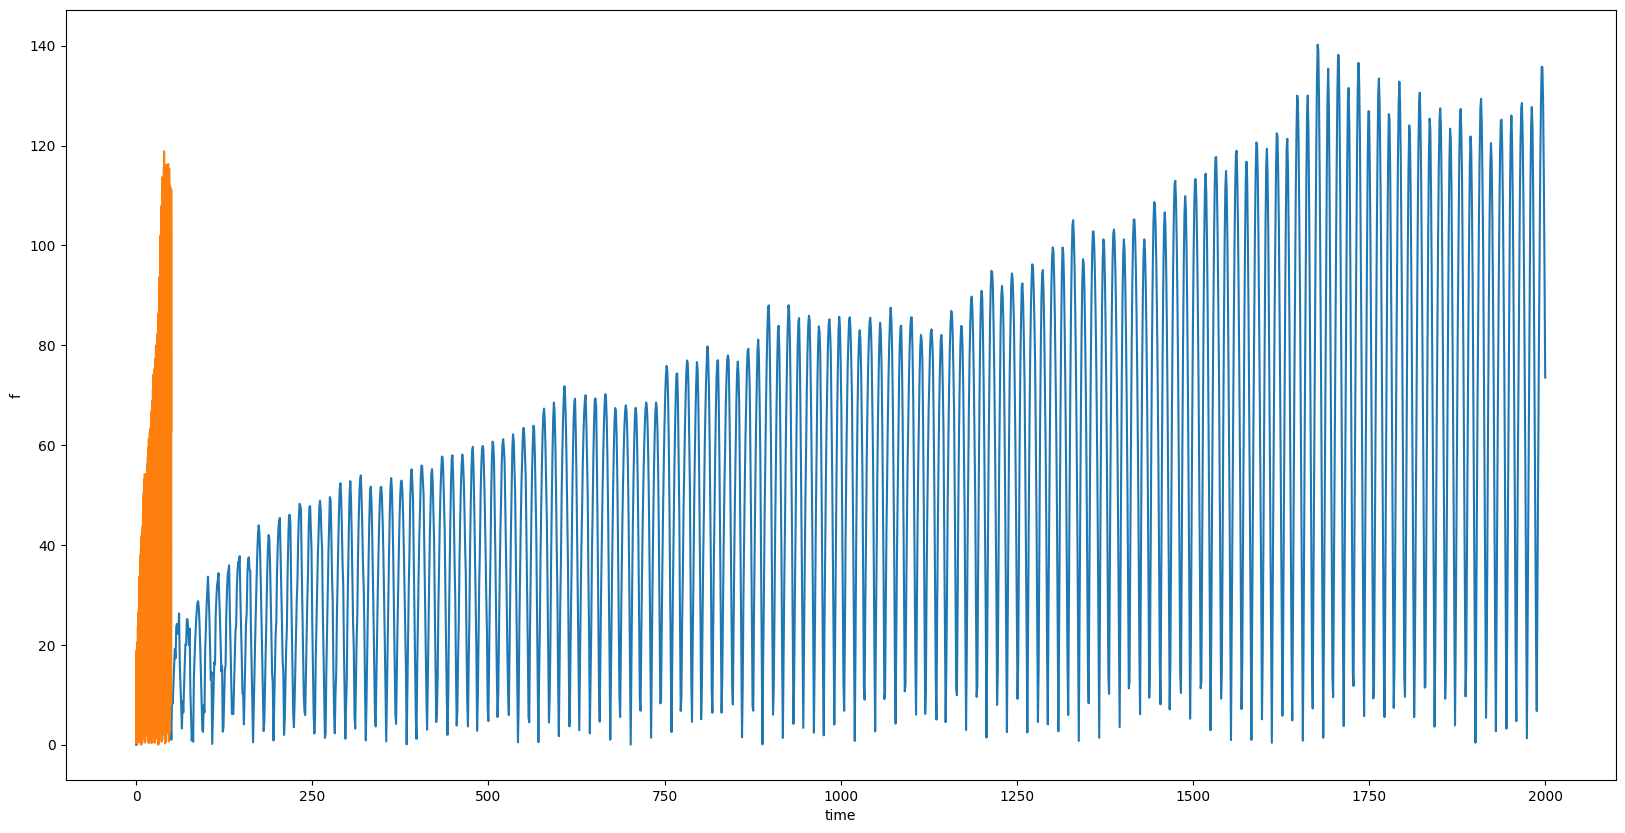

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
5/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
6/50
0
100
200
300
400

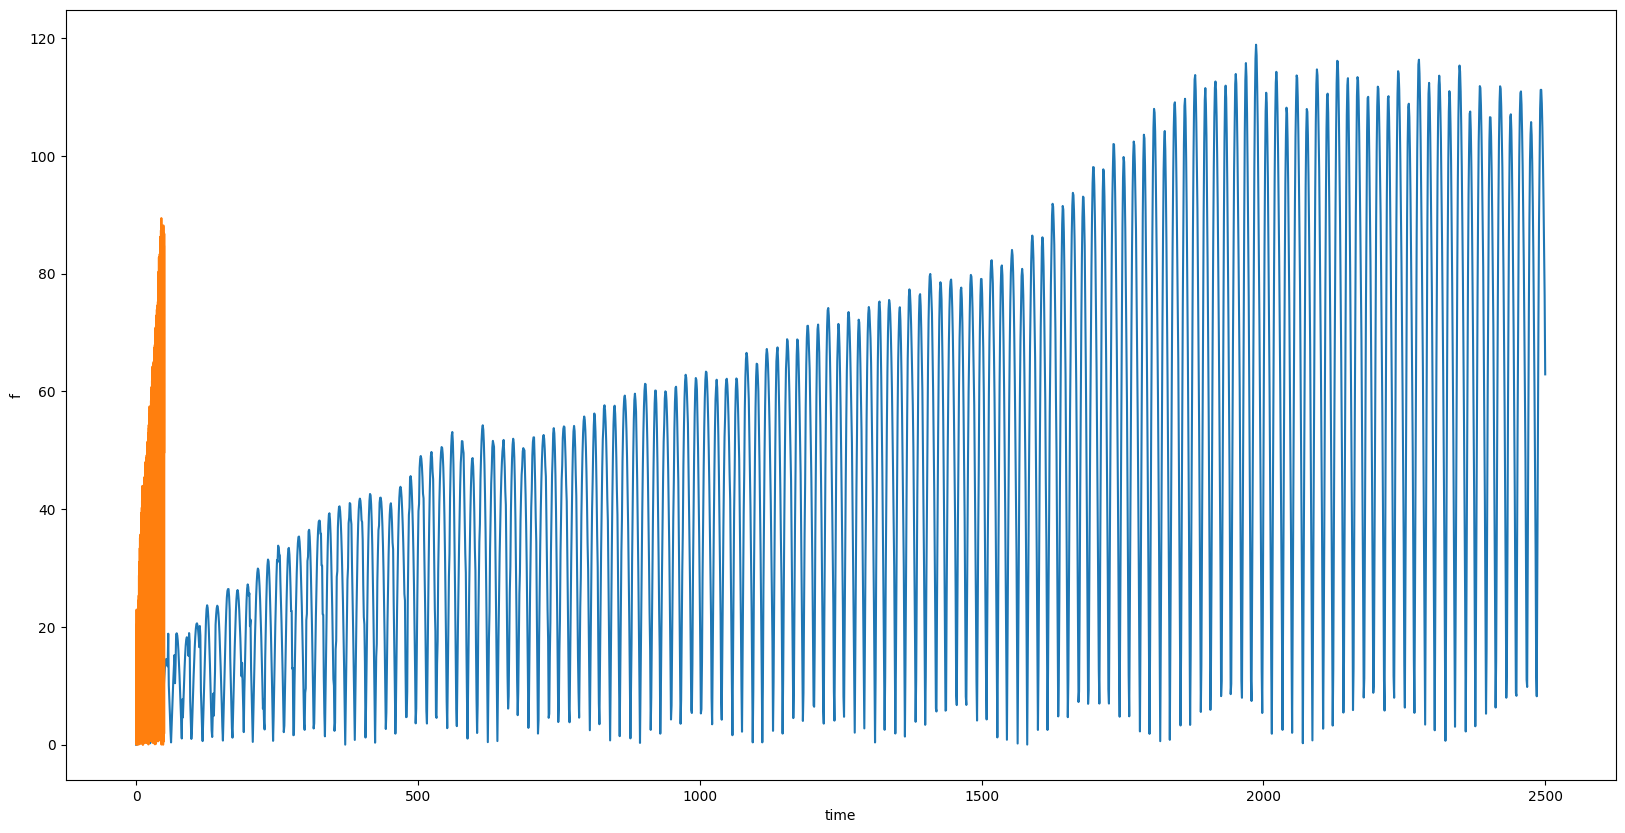

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
4/50
0
100
200
300
400
500
6

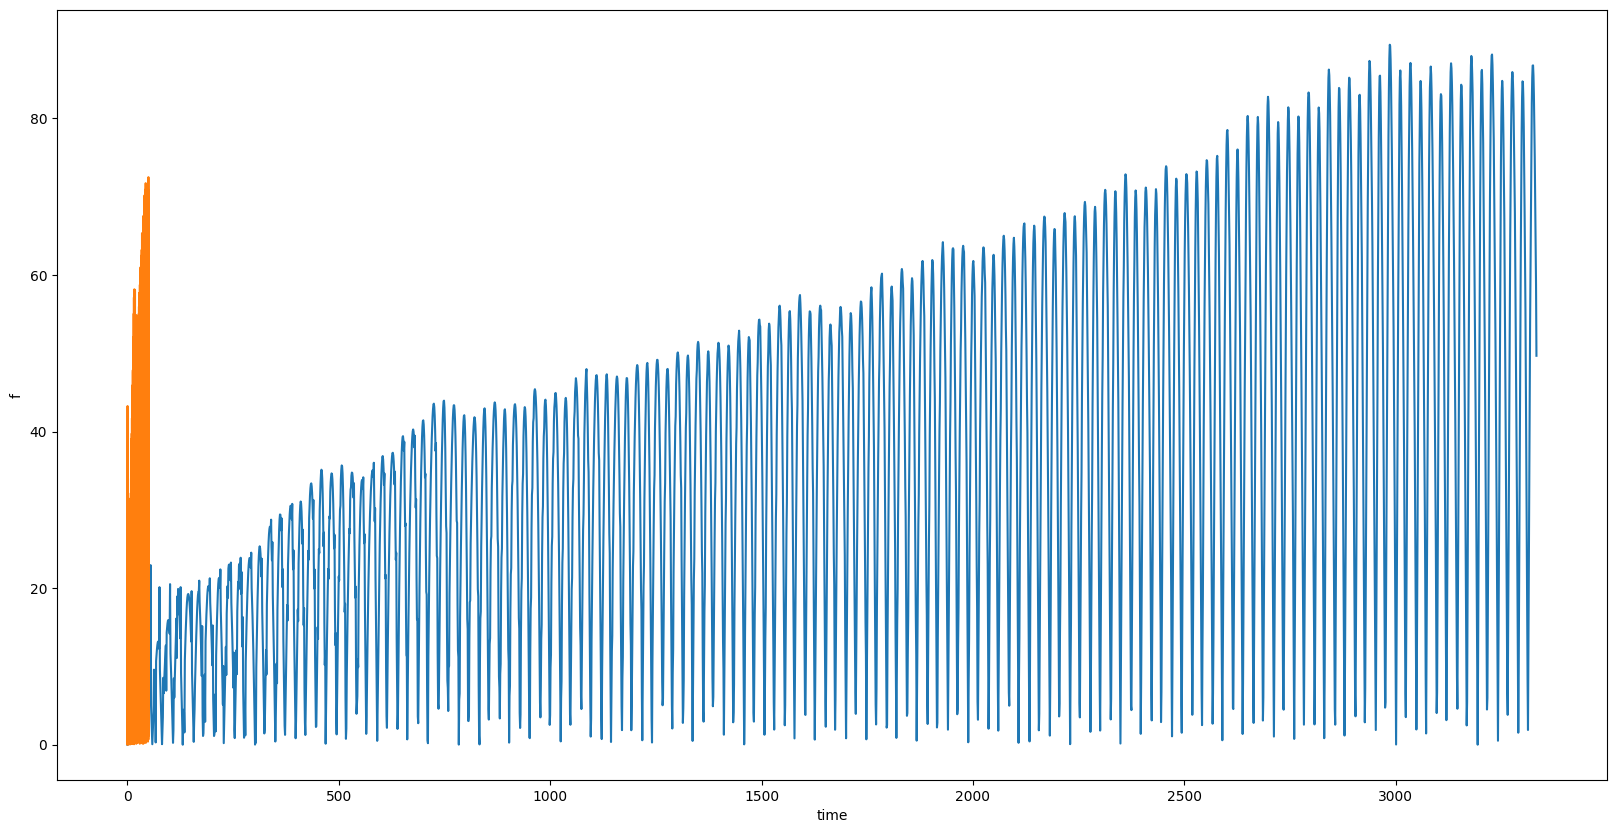

0/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
1/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
2/50
0
100
200

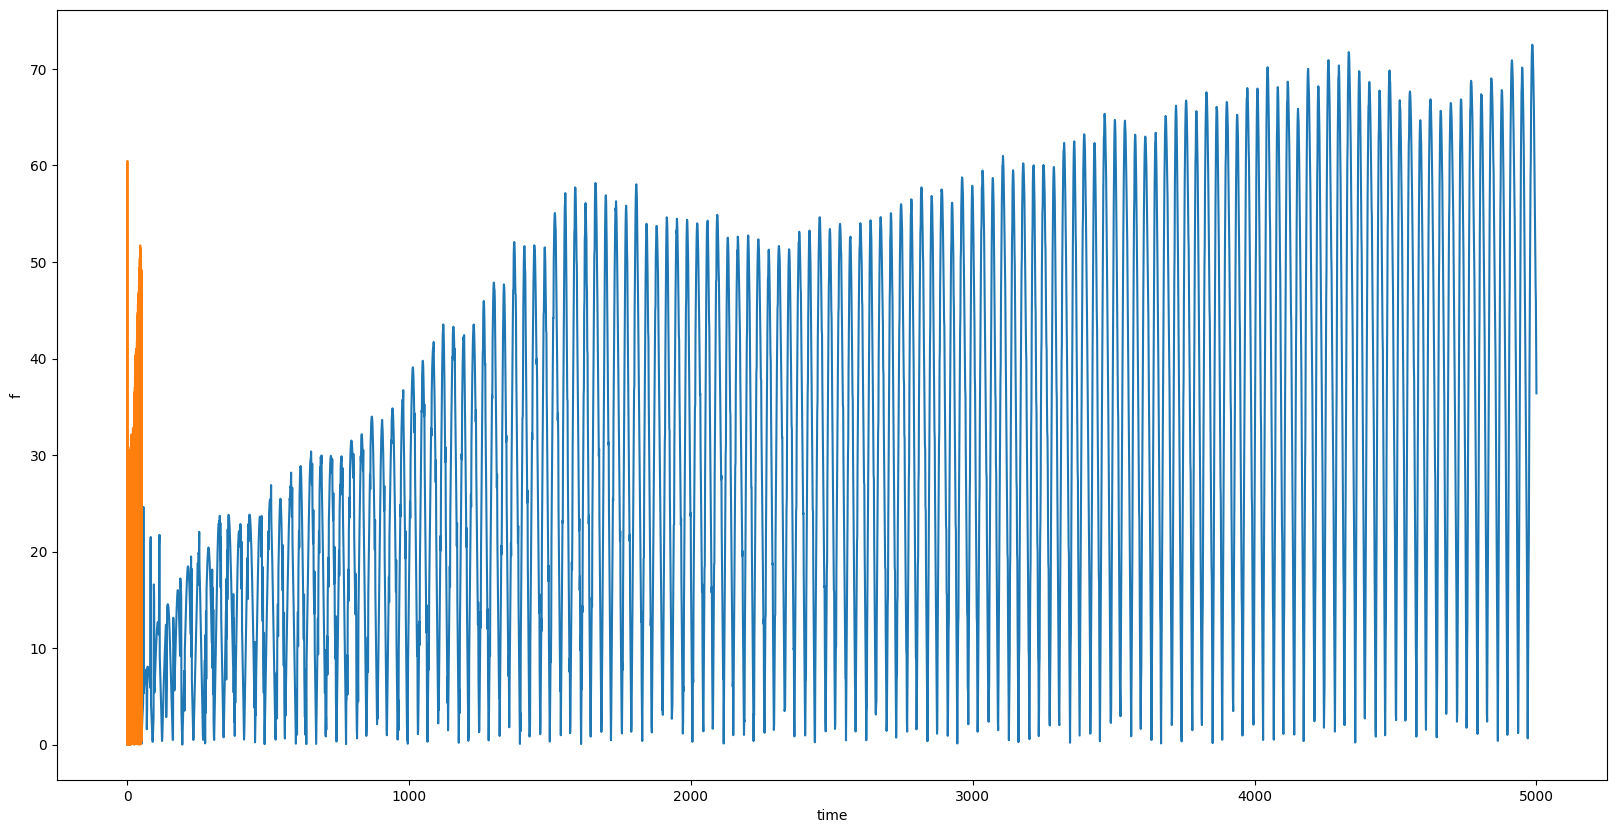

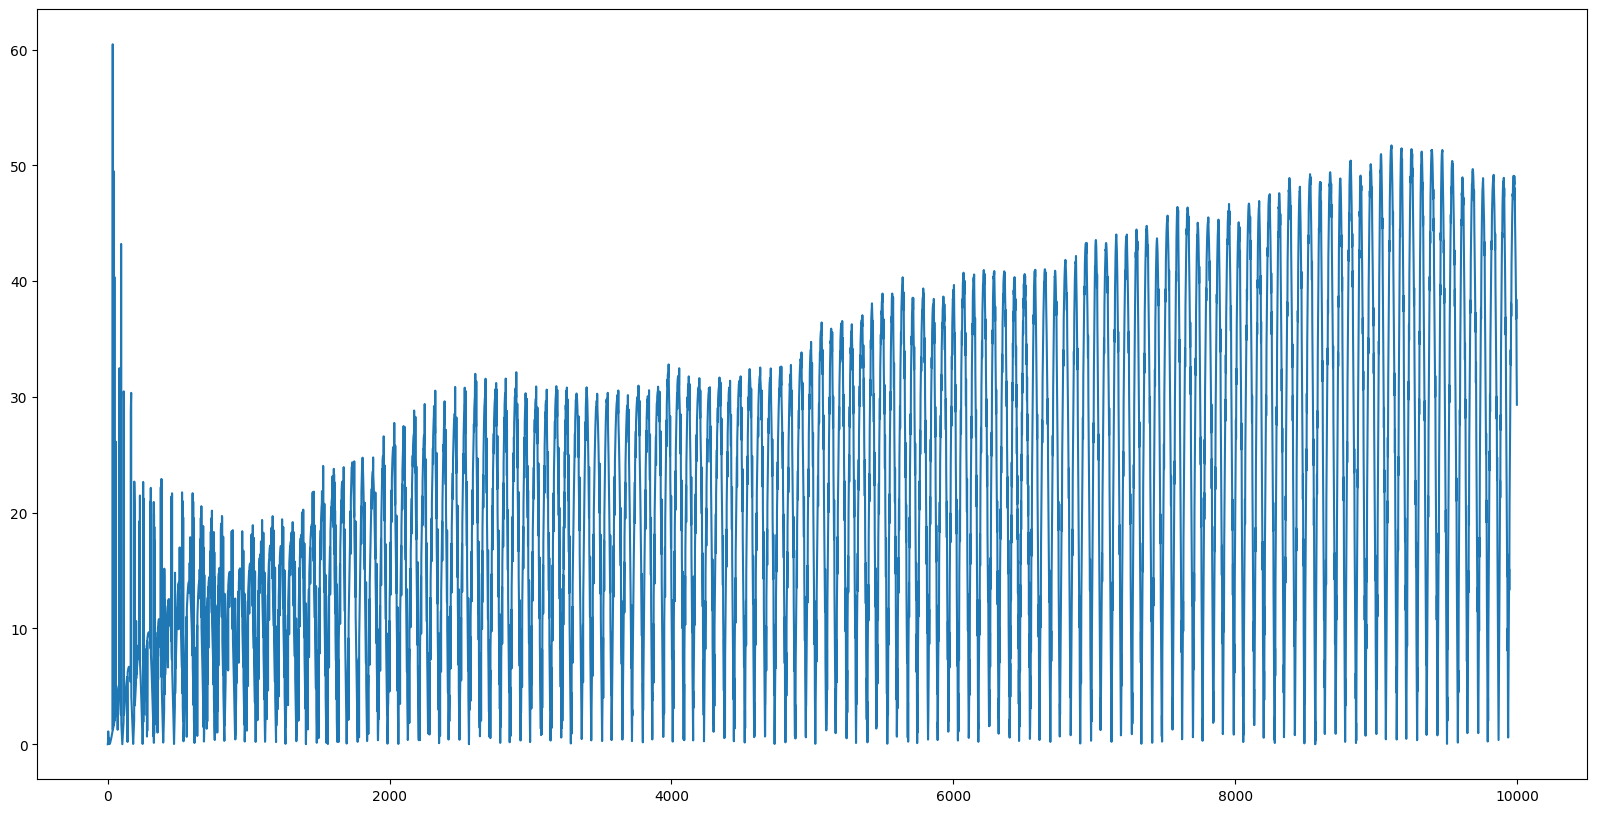

In [ ]:
# t_list = np.flip(np.arange(0.005, 0.1, 0.01))
# for t in t_list:
#     err = f(T=50, delta_t=t, N=50)
#     plt.plot(err)
#     # avg = moving_avg(err,get_period(err))
#     # plt.plot(,avg)
#     np.save("N=50/f(T=50,delta_t=" + str(round(t, 3)) + ").npy", err)

from concurrent.futures import ProcessPoolExecutor

# Assuming the 'f' function is defined elsewhere
def compute_and_save(T, delta_t, N):
    err = f(T=T, delta_t=delta_t, N=N)
    filename = f"N={N}/f(T={T},delta_t={round(delta_t, 3)}).npy"
    np.save(filename, err)
    return err, delta_t

# Your time list
t_list = np.flip(np.arange(0.005, 0.1, 0.01))

# Prepare for parallel execution
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(compute_and_save, 5, t, 5) for t in t_list]
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

# After parallel execution, plot the results
results.sort(key=lambda x: x[1])  # Sort results by delta_t for plotting
for err, delta_t in results:
    plt.plot(err)
    # Here you would calculate the moving average and plot it
    # avg = moving_avg(err, get_period(err))
    # plt.plot(avg)

plt.show()  # Show all plots at the end


f(T=50,delta_t=0.005).npy
0.005
f(T=50,delta_t=0.01).npy
0.01
f(T=50,delta_t=0.015).npy
0.015
f(T=50,delta_t=0.02).npy
0.02
f(T=50,delta_t=0.025).npy
0.025
f(T=50,delta_t=0.03).npy
0.03
f(T=50,delta_t=0.035).npy
0.035
f(T=50,delta_t=0.04).npy
0.04
f(T=50,delta_t=0.045).npy
0.045
f(T=50,delta_t=0.05).npy
0.05
f(T=50,delta_t=0.055).npy


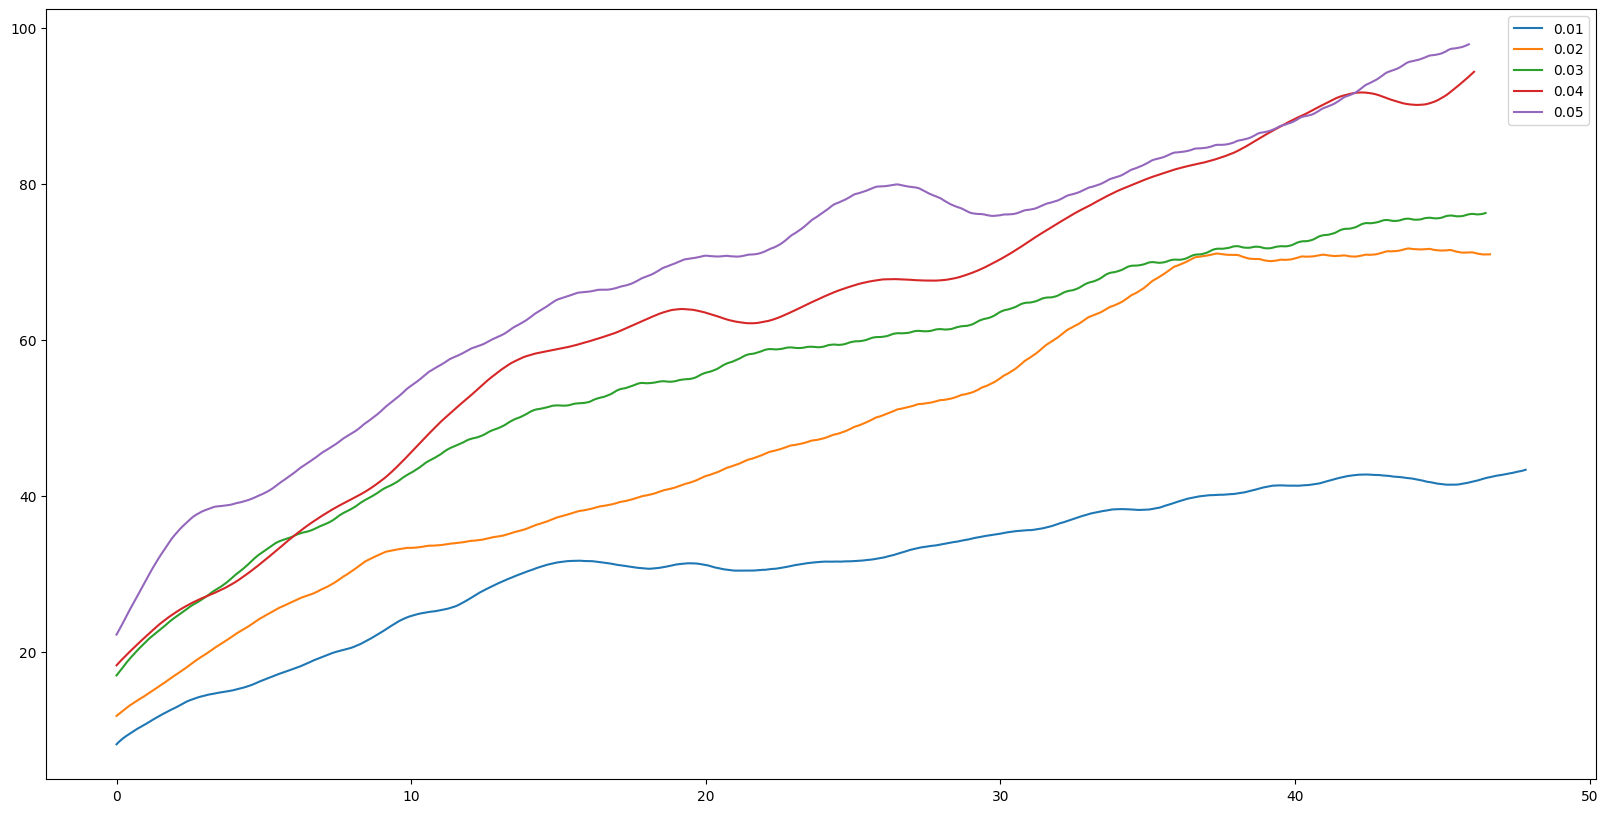

0.055
f(T=50,delta_t=0.06).npy
0.06
f(T=50,delta_t=0.065).npy
0.065
f(T=50,delta_t=0.07).npy
0.07
f(T=50,delta_t=0.075).npy
0.075
f(T=50,delta_t=0.08).npy
0.08
f(T=50,delta_t=0.085).npy
0.085
f(T=50,delta_t=0.09).npy
0.09
f(T=50,delta_t=0.095).npy
0.095


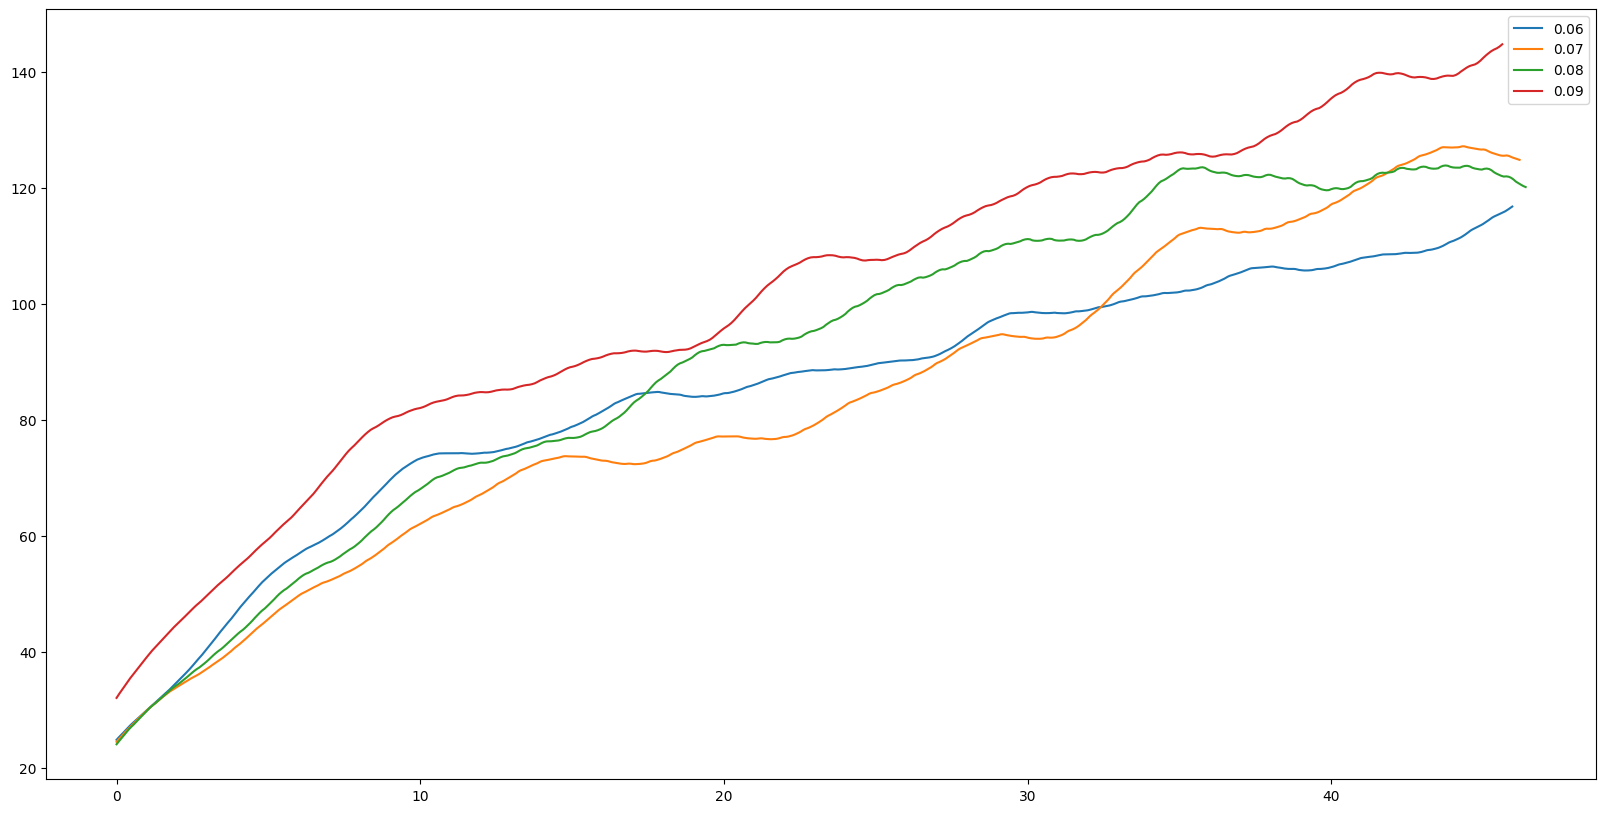

In [47]:
import os


def period_for_list(delta_t):
    return int(round(period_in_t / delta_t, 0))


data_avg = []
data_t_avg = []

folder_name = "N=50"  # replace 'path_to_the_folder' with the actual path
directory = os.path.join(os.getcwd(), folder_name)

t_list = np.arange(0.005, 0.1, 0.005)
index = 0
lgd = []
count = 0
# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".npy"):
        if "f" in filename:  # and filename == 'f(T=50,delta_t=0.055).npy':
            print(filename)
            if count >= 10:
                plt.legend(lgd)
                plt.show()
                count = 0
                lgd = []

            delta_t = round(t_list[index], 3)
            print(delta_t)
            arr = np.load(os.path.join(directory, filename))
            # plt.plot(arr)
            # avg = moving_avg(arr, int(round(3*get_period(arr),0)))
            # avg2 = moving_avg(avg,int(round(3*get_period(avg),0)))#int(round(get_period(avg),0)))
            # plt.plot(avg)
            # plt.plot(avg2)
            avg = moving_avg(
                arr, int(round(5 * get_period(arr), 0))
            )  # period_for_list(delta_t))
            avg = moving_avg(avg, int(round(5 * get_period(avg), 0)))
            # avg = moving_avg(avg, int(round(get_period(avg),0)))
            # avg = moving_avg(avg, int(round(get_period(avg),0)))
            T = np.arange(0, 50, delta_t)
            # plt.plot(T,arr[:len(T)])
            if int(delta_t / 0.005) % 2 == 0:
                data_avg.append(avg)
                data_t_avg.append(T[: len(avg)])
                plt.plot(T[: len(avg)], avg)
                lgd.append(str(delta_t))
            index += 1

            count += 1

            # plt.show()
            # # Store the numpy array in the dictionary
            # arrays_dict[filename] = array
plt.legend(lgd)
plt.show()

R-squared value for square root fit: 0.9549
R-squared value for square root fit: nan
R-squared value for square root fit: 0.9824
R-squared value for square root fit: 0.9817
R-squared value for square root fit: 0.9695
R-squared value for square root fit: 0.9445
R-squared value for square root fit: nan
R-squared value for square root fit: 0.9817
R-squared value for square root fit: 0.9880


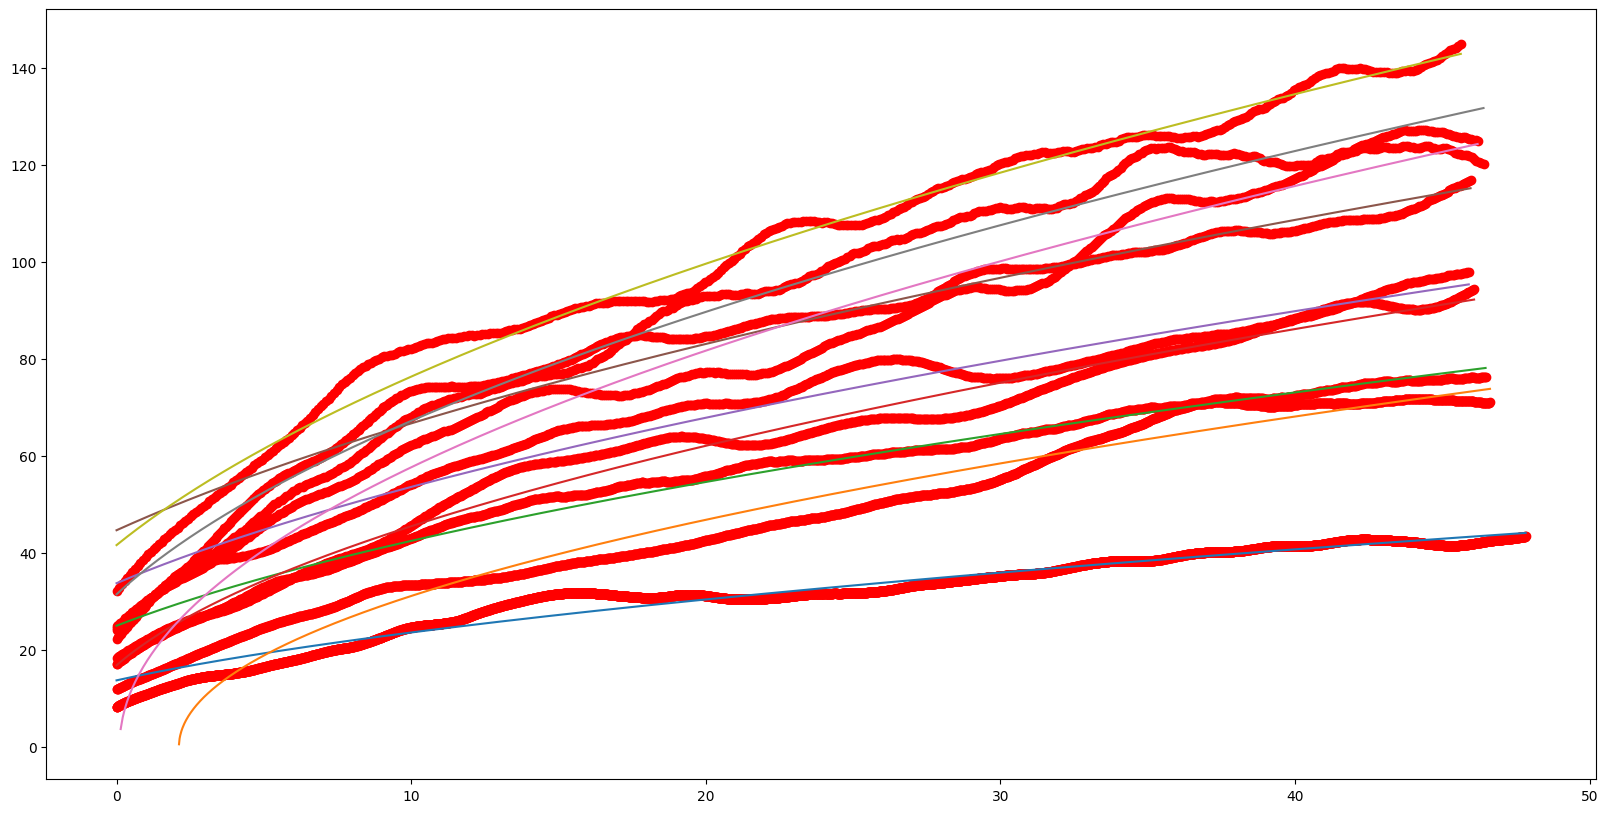

In [54]:
def fit_square_root(x, y):
    """
    Fits a square root function to the given data and evaluates its goodness of fit.

    Parameters:
    - x (list): List of x-values.
    - y (list): List of y-values.

    Returns:
    - float: R-squared value for the square root fit.
    """

    x = np.array(x)
    y = np.array(y)

    # Square the y-values to linearize the relationship
    y_squared = y**2

    # Fit a linear model to the transformed data
    coefficients = np.polyfit(x, y_squared, 1)
    p = np.poly1d(coefficients)

    # Calculate the fitted y-values using the square root function
    y_fit = np.sqrt(p(x))

    # Calculate R-squared value for the fit
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot original data and fitted curve
    plt.scatter(x, y, color="red", label="Original Data")
    plt.plot(x, y_fit, label="Square Root Fit")
    # plt.legend()
    # plt.show()

    return r_squared


# Example usage
for i in range(len(data_t_avg)):
    x_values = data_t_avg[i]
    y_values = data_avg[i]
    r2 = fit_square_root(x_values, y_values)
    print(f"R-squared value for square root fit: {r2:.4f}")